In [2]:
import os
import numpy as np
import zipfile
import requests
from tqdm import tqdm
import torch
import torch.nn as nn
# import torch.nn.functional as F
from torchvision import datasets, transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, DataLoader
from sklearn.model_selection import train_test_split
from torch import optim
from pathlib import Path
import json
import wandb
import time
import copy

In [3]:
dataset_url = "https://storage.googleapis.com/wandb_datasets/nature_12K.zip"
dataset_zip_path = "/kaggle/working/nature_12K.zip"
dataset_dir = "nature_12K"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Parameters
num_classes = 10  # For iNaturalist (adjust if needed)
batch_size = 16
num_epochs = 10
learning_rate = 1e-3

In [4]:
if not os.path.exists(dataset_dir):
    if not os.path.exists(dataset_zip_path):
        print("Downloading iNaturalist-12K...")
        response = requests.get(dataset_url, stream=True)
        total_size = int(response.headers.get('content-length', 0))
        with open(dataset_zip_path, 'wb') as f, tqdm(
            desc=dataset_zip_path,
            total=total_size,
            unit='iB',
            unit_scale=True,
            unit_divisor=1024,
        ) as bar:
            for data in response.iter_content(chunk_size=1024):
                size = f.write(data)
                bar.update(size)

/kaggle/working/nature_12K.zip: 100%|██████████| 3.55G/3.55G [02:02<00:00, 31.1MiB/s] 


In [5]:
if not os.path.exists(dataset_dir):
    print("Extracting dataset...")
    with zipfile.ZipFile(dataset_zip_path, 'r') as zip_ref:
        zip_ref.extractall(".")

Extracting dataset...


In [6]:
def prepare_datasets(data_dir, val_split=0.2, batch_size=32, image_size=(224, 224)):
    data_dir = Path(data_dir)

    # Define transforms (customize as needed)
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),  # Converts to [0, 1] and CxHxW
        transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),  # Normalize RGB
    ])

    # Load training and testing datasets
    full_train_dataset = ImageFolder(root=data_dir / "train", transform=transform)
    test_dataset = ImageFolder(root=data_dir / "val", transform=transform)

    # Create validation split from training set
    val_size = int(val_split * len(full_train_dataset))
    train_size = len(full_train_dataset) - val_size

    train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

    # Extract X and Y by iterating over DataLoader batches if needed
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    # # Convert to X, Y tensors
    # def extract_XY(loader):
    #     for X, Y in loader:
    #         return X, Y

    # X_train, Y_train = extract_XY(train_loader)
    # X_val, Y_val = extract_XY(val_loader)
    # X_test, Y_test = extract_XY(test_loader)

    return train_loader, val_loader, test_loader

In [7]:
train_loader, val_loader, test_loader = prepare_datasets(
    data_dir='/kaggle/working/inaturalist_12K', val_split=0.2, batch_size=64, image_size=(224, 224)
)

In [14]:
api_key = "7040d84a3ed65a967eb3389dd6fe774b418576ed" 
wandb.login(key=api_key)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [9]:
def train(config=None):
    # Initialize wandb
    with wandb.init(config=config):
        config = wandb.config
        
        # Initialize best_val_acc at the beginning of the function
        best_val_acc = 0.0

# Set random seed for reproducibility
        torch.manual_seed(config.seed)
        np.random.seed(config.seed)

        # Data augmentation and normalization based on config
        if config.use_augmentation:
            train_transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(10),
                transforms.ColorJitter(brightness=0.2, contrast=0.2),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
            ])
        else:
            train_transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
            ])

        val_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])
        ])

        # Load dataset
        train_dataset = datasets.ImageFolder(
            root='/kaggle/working/inaturalist_12K/train',  # Update to match your dataset path
            transform=train_transform
        )
        
        # Split into train and validation
        train_indices, val_indices = train_test_split(
            list(range(len(train_dataset))),
            test_size=0.2,
            stratify=train_dataset.targets,
            random_state=config.seed
        )
        
        train_subset = torch.utils.data.Subset(train_dataset, train_indices)
        val_subset = torch.utils.data.Subset(train_dataset, val_indices)
        
        train_loader = DataLoader(
            train_subset,
            batch_size=config.batch_size,
            shuffle=True,
            num_workers=4
        )
        
        val_loader = DataLoader(
            val_subset,
            batch_size=config.batch_size,
            shuffle=False,
            num_workers=4
        )

        model = models.resnet50(pretrained=True)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, 10)  # Replace last layer

        # Freeze all layers
        for param in model.parameters():
            param.requires_grad = False
        
        # Replace the final layer (fc) for 10-class classification
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, 10)
        
        # Only the final layer's parameters will be updated
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = model.to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.fc.parameters(), lr=config.learning_rate)

        # The rest of the training code remains the same
        for epoch in range(config.epochs):
            # Training phase
            model.train()
            train_loss = 0
            train_correct = 0
            train_total = 0

            for batch_idx, (inputs, targets) in enumerate(train_loader):
                inputs, targets = inputs.to(device), targets.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                _, predicted = outputs.max(1)
                train_total += targets.size(0)
                train_correct += predicted.eq(targets).sum().item()

                if batch_idx % 100 == 0:
                    print(f'Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item():.4f}')

            train_acc = 100. * train_correct / train_total

            # Validation phase
            model.eval()
            val_loss = 0
            val_correct = 0
            val_total = 0

            with torch.no_grad():
                for inputs, targets in val_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)

                    val_loss += loss.item()
                    _, predicted = outputs.max(1)
                    val_total += targets.size(0)
                    val_correct += predicted.eq(targets).sum().item()

            val_acc = 100. * val_correct / val_total

            # Log metrics to wandb
            wandb.log({
                "epoch": epoch,
                "train_loss": train_loss / len(train_loader),
                "train_acc": train_acc,
                "val_loss": val_loss / len(val_loader),
                "val_acc": val_acc
            })

            # Save best model
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(model.state_dict(), 'best_model.pth')
                print(f"Best model saved with val_acc: {val_acc:.2f}% at epoch {epoch}")

            print(f'Epoch: {epoch}, Train Loss: {train_loss/len(train_loader):.4f}, '
                  f'Train Acc: {train_acc:.2f}%, Val Loss: {val_loss/len(val_loader):.4f}, '
                  f'Val Acc: {val_acc:.2f}%')
        

In [10]:
# Updated sweep configuration
sweep_config = {
    'method': 'random',  # or 'grid' or 'bayes'
    'metric': {
        'name': 'val_acc',
        'goal': 'maximize'
    },
    'parameters': {
        'learning_rate': {
            'min': 1e-5,
            'max': 1e-3
        },
        'batch_size': {
            'values': [32, 64, 128]
        },
        'epochs': {
            'value': 5
        },
        'seed': {
            'values': [42, 2023, 7]
        },
        'use_augmentation': {
            'values': [True, False]
        },
        'trainable_layers': {
            'values': [1, 2, 3, 5, 7]  # Train different numbers of layers from the end
        }
    }
}

sweep_id = wandb.sweep(sweep_config, project="da6401_partB_01")  # Replace with your wandb project name
# Run the sweep 50 times
wandb.agent(sweep_id, function=train, count=50)

Create sweep with ID: 7uxv9ux3
Sweep URL: https://wandb.ai/da24m004-iitmaana/da6401_partB_01/sweeps/7uxv9ux3


wandb: Agent Starting Run: azmcymsl with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0006949258369787645
wandb: 	seed: 7
wandb: 	trainable_layers: 5
wandb: 	use_augmentation: False
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 205MB/s]


Epoch: 0, Batch: 0, Loss: 2.4081
Epoch: 0, Batch: 100, Loss: 1.2058
Best model saved with val_acc: 70.45% at epoch 0
Epoch: 0, Train Loss: 1.2552, Train Acc: 62.60%, Val Loss: 0.9108, Val Acc: 70.45%
Epoch: 1, Batch: 0, Loss: 0.7738
Epoch: 1, Batch: 100, Loss: 0.7431
Best model saved with val_acc: 71.75% at epoch 1
Epoch: 1, Train Loss: 0.8432, Train Acc: 73.30%, Val Loss: 0.8489, Val Acc: 71.75%
Epoch: 2, Batch: 0, Loss: 0.7596
Epoch: 2, Batch: 100, Loss: 0.7352
Best model saved with val_acc: 73.85% at epoch 2
Epoch: 2, Train Loss: 0.7815, Train Acc: 75.08%, Val Loss: 0.7995, Val Acc: 73.85%
Epoch: 3, Batch: 0, Loss: 0.7122
Epoch: 3, Batch: 100, Loss: 0.4950
Epoch: 3, Train Loss: 0.7242, Train Acc: 76.38%, Val Loss: 0.7941, Val Acc: 73.65%
Epoch: 4, Batch: 0, Loss: 0.8440
Epoch: 4, Batch: 100, Loss: 0.5876
Best model saved with val_acc: 74.00% at epoch 4
Epoch: 4, Train Loss: 0.7073, Train Acc: 77.20%, Val Loss: 0.7985, Val Acc: 74.00%


epoch,▁▃▅▆█
train_acc,▁▆▇██
train_loss,█▃▂▁▁
val_acc,▁▄█▇█
val_loss,█▄▁▁▁
epoch,4
train_acc,77.19715
train_loss,0.70732
val_acc,74
val_loss,0.79854


wandb: Agent Starting Run: 6dot6bda with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.00020214931219947888
wandb: 	seed: 2023
wandb: 	trainable_layers: 5
wandb: 	use_augmentation: True


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 0, Batch: 0, Loss: 2.3679
Epoch: 0, Batch: 100, Loss: 1.7605
Epoch: 0, Batch: 200, Loss: 1.2425
Best model saved with val_acc: 65.60% at epoch 0
Epoch: 0, Train Loss: 1.6400, Train Acc: 53.22%, Val Loss: 1.2001, Val Acc: 65.60%
Epoch: 1, Batch: 0, Loss: 1.1076
Epoch: 1, Batch: 100, Loss: 1.1210
Epoch: 1, Batch: 200, Loss: 1.1682
Best model saved with val_acc: 68.15% at epoch 1
Epoch: 1, Train Loss: 1.1326, Train Acc: 66.88%, Val Loss: 1.0235, Val Acc: 68.15%
Epoch: 2, Batch: 0, Loss: 1.0213
Epoch: 2, Batch: 100, Loss: 1.1942
Epoch: 2, Batch: 200, Loss: 0.8030
Best model saved with val_acc: 69.25% at epoch 2
Epoch: 2, Train Loss: 1.0021, Train Acc: 68.75%, Val Loss: 0.9510, Val Acc: 69.25%
Epoch: 3, Batch: 0, Loss: 1.0321
Epoch: 3, Batch: 100, Loss: 0.9392
Epoch: 3, Batch: 200, Loss: 0.9176
Best model saved with val_acc: 71.45% at epoch 3
Epoch: 3, Train Loss: 0.9461, Train Acc: 69.87%, Val Loss: 0.8959, Val Acc: 71.45%
Epoch: 4, Batch: 0, Loss: 1.0389
Epoch: 4, Batch: 100, Loss:

epoch,▁▃▅▆█
train_acc,▁▆▇██
train_loss,█▃▂▁▁
val_acc,▁▄▅██
val_loss,█▄▂▁▁
epoch,4
train_acc,70.70884
train_loss,0.90372
val_acc,71.15
val_loss,0.88791


wandb: Agent Starting Run: sc3tt2vd with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0004893189174938811
wandb: 	seed: 42
wandb: 	trainable_layers: 3
wandb: 	use_augmentation: False


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 0, Batch: 0, Loss: 2.5007
Epoch: 0, Batch: 100, Loss: 1.3915
Epoch: 0, Batch: 200, Loss: 0.7433
Best model saved with val_acc: 71.95% at epoch 0
Epoch: 0, Train Loss: 1.2647, Train Acc: 62.60%, Val Loss: 0.8761, Val Acc: 71.95%
Epoch: 1, Batch: 0, Loss: 0.9239
Epoch: 1, Batch: 100, Loss: 1.1203
Epoch: 1, Batch: 200, Loss: 0.9286
Best model saved with val_acc: 76.35% at epoch 1
Epoch: 1, Train Loss: 0.8913, Train Acc: 71.46%, Val Loss: 0.7513, Val Acc: 76.35%
Epoch: 2, Batch: 0, Loss: 0.8175
Epoch: 2, Batch: 100, Loss: 0.8285
Epoch: 2, Batch: 200, Loss: 0.9328
Best model saved with val_acc: 76.40% at epoch 2
Epoch: 2, Train Loss: 0.8161, Train Acc: 73.37%, Val Loss: 0.7351, Val Acc: 76.40%
Epoch: 3, Batch: 0, Loss: 0.6660
Epoch: 3, Batch: 100, Loss: 0.9460
Epoch: 3, Batch: 200, Loss: 1.2596
Best model saved with val_acc: 77.95% at epoch 3
Epoch: 3, Train Loss: 0.7703, Train Acc: 74.85%, Val Loss: 0.7174, Val Acc: 77.95%
Epoch: 4, Batch: 0, Loss: 0.6034
Epoch: 4, Batch: 100, Loss:

epoch,▁▃▅▆█
train_acc,▁▆▇██
train_loss,█▃▂▁▁
val_acc,▁▆▆█▆
val_loss,█▃▂▁▁
epoch,4
train_acc,75.24691
train_loss,0.75514
val_acc,76.5
val_loss,0.70895


wandb: Agent Starting Run: ilecde2c with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.00034290171881632347
wandb: 	seed: 7
wandb: 	trainable_layers: 5
wandb: 	use_augmentation: False


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 0, Batch: 0, Loss: 2.3902
Epoch: 0, Batch: 100, Loss: 1.3835
Epoch: 0, Batch: 200, Loss: 1.1144
Best model saved with val_acc: 70.70% at epoch 0
Epoch: 0, Train Loss: 1.3739, Train Acc: 60.11%, Val Loss: 0.9673, Val Acc: 70.70%
Epoch: 1, Batch: 0, Loss: 0.7527
Epoch: 1, Batch: 100, Loss: 1.0639
Epoch: 1, Batch: 200, Loss: 0.8046
Best model saved with val_acc: 72.30% at epoch 1
Epoch: 1, Train Loss: 0.9207, Train Acc: 71.32%, Val Loss: 0.8645, Val Acc: 72.30%
Epoch: 2, Batch: 0, Loss: 0.8570
Epoch: 2, Batch: 100, Loss: 0.8712
Epoch: 2, Batch: 200, Loss: 0.7950
Best model saved with val_acc: 72.55% at epoch 2
Epoch: 2, Train Loss: 0.8397, Train Acc: 73.41%, Val Loss: 0.8126, Val Acc: 72.55%
Epoch: 3, Batch: 0, Loss: 0.7466
Epoch: 3, Batch: 100, Loss: 0.4726
Epoch: 3, Batch: 200, Loss: 0.4162
Best model saved with val_acc: 74.00% at epoch 3
Epoch: 3, Train Loss: 0.7856, Train Acc: 74.90%, Val Loss: 0.7965, Val Acc: 74.00%
Epoch: 4, Batch: 0, Loss: 0.7313
Epoch: 4, Batch: 100, Loss:

epoch,▁▃▅▆█
train_acc,▁▆▇██
train_loss,█▃▂▁▁
val_acc,▁▄▅██
val_loss,█▄▂▁▂
epoch,4
train_acc,75.2219
train_loss,0.76649
val_acc,73.85
val_loss,0.80966


wandb: Agent Starting Run: 1dlglbia with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.00019217419263754012
wandb: 	seed: 2023
wandb: 	trainable_layers: 2
wandb: 	use_augmentation: True


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 0, Batch: 0, Loss: 2.3679
Epoch: 0, Batch: 100, Loss: 1.7770
Epoch: 0, Batch: 200, Loss: 1.2660
Best model saved with val_acc: 65.35% at epoch 0
Epoch: 0, Train Loss: 1.6567, Train Acc: 52.87%, Val Loss: 1.2175, Val Acc: 65.35%
Epoch: 1, Batch: 0, Loss: 1.1273
Epoch: 1, Batch: 100, Loss: 1.1345
Epoch: 1, Batch: 200, Loss: 1.1767
Best model saved with val_acc: 68.10% at epoch 1
Epoch: 1, Train Loss: 1.1463, Train Acc: 66.76%, Val Loss: 1.0326, Val Acc: 68.10%
Epoch: 2, Batch: 0, Loss: 1.0307
Epoch: 2, Batch: 100, Loss: 1.1988
Epoch: 2, Batch: 200, Loss: 0.8109
Best model saved with val_acc: 69.15% at epoch 2
Epoch: 2, Train Loss: 1.0111, Train Acc: 68.61%, Val Loss: 0.9576, Val Acc: 69.15%
Epoch: 3, Batch: 0, Loss: 1.0379
Epoch: 3, Batch: 100, Loss: 0.9494
Epoch: 3, Batch: 200, Loss: 0.9264
Best model saved with val_acc: 71.50% at epoch 3
Epoch: 3, Train Loss: 0.9530, Train Acc: 69.65%, Val Loss: 0.9004, Val Acc: 71.50%
Epoch: 4, Batch: 0, Loss: 1.0432
Epoch: 4, Batch: 100, Loss:

epoch,▁▃▅▆█
train_acc,▁▇▇██
train_loss,█▃▂▁▁
val_acc,▁▄▅█▇
val_loss,█▄▂▁▁
epoch,4
train_acc,70.52132
train_loss,0.90955
val_acc,71.05
val_loss,0.89139


wandb: Agent Starting Run: 07whow0p with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 0.000919359530137179
wandb: 	seed: 42
wandb: 	trainable_layers: 3
wandb: 	use_augmentation: True


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 0, Batch: 0, Loss: 2.4456
Epoch: 0, Batch: 100, Loss: 0.9902
Best model saved with val_acc: 70.30% at epoch 0
Epoch: 0, Train Loss: 1.2894, Train Acc: 60.02%, Val Loss: 0.9429, Val Acc: 70.30%
Epoch: 1, Batch: 0, Loss: 0.8525
Epoch: 1, Batch: 100, Loss: 0.7973
Best model saved with val_acc: 73.00% at epoch 1
Epoch: 1, Train Loss: 0.9364, Train Acc: 69.20%, Val Loss: 0.8371, Val Acc: 73.00%
Epoch: 2, Batch: 0, Loss: 0.8886
Epoch: 2, Batch: 100, Loss: 0.6961
Epoch: 2, Train Loss: 0.8787, Train Acc: 71.00%, Val Loss: 0.8165, Val Acc: 72.90%
Epoch: 3, Batch: 0, Loss: 0.6568
Epoch: 3, Batch: 100, Loss: 0.9779
Epoch: 3, Train Loss: 0.8240, Train Acc: 72.61%, Val Loss: 0.8263, Val Acc: 73.00%
Epoch: 4, Batch: 0, Loss: 0.7778
Epoch: 4, Batch: 100, Loss: 0.8155
Epoch: 4, Train Loss: 0.8193, Train Acc: 72.68%, Val Loss: 0.8227, Val Acc: 72.50%


epoch,▁▃▅▆█
train_acc,▁▆▇██
train_loss,█▃▂▁▁
val_acc,▁███▇
val_loss,█▂▁▂▁
epoch,4
train_acc,72.68409
train_loss,0.81927
val_acc,72.5
val_loss,0.82273


wandb: Agent Starting Run: 9yjwjjlr with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001701439910958795
wandb: 	seed: 2023
wandb: 	trainable_layers: 5
wandb: 	use_augmentation: True


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 0, Batch: 0, Loss: 2.3679
Epoch: 0, Batch: 100, Loss: 1.8160
Epoch: 0, Batch: 200, Loss: 1.3243
Best model saved with val_acc: 64.85% at epoch 0
Epoch: 0, Train Loss: 1.6970, Train Acc: 51.83%, Val Loss: 1.2611, Val Acc: 64.85%
Epoch: 1, Batch: 0, Loss: 1.1771
Epoch: 1, Batch: 100, Loss: 1.1692
Epoch: 1, Batch: 200, Loss: 1.1992
Best model saved with val_acc: 67.95% at epoch 1
Epoch: 1, Train Loss: 1.1812, Train Acc: 66.33%, Val Loss: 1.0566, Val Acc: 67.95%
Epoch: 2, Batch: 0, Loss: 1.0556
Epoch: 2, Batch: 100, Loss: 1.2113
Epoch: 2, Batch: 200, Loss: 0.8334
Best model saved with val_acc: 68.75% at epoch 2
Epoch: 2, Train Loss: 1.0345, Train Acc: 68.27%, Val Loss: 0.9750, Val Acc: 68.75%
Epoch: 3, Batch: 0, Loss: 1.0524
Epoch: 3, Batch: 100, Loss: 0.9747
Epoch: 3, Batch: 200, Loss: 0.9476
Best model saved with val_acc: 71.10% at epoch 3
Epoch: 3, Train Loss: 0.9709, Train Acc: 69.36%, Val Loss: 0.9131, Val Acc: 71.10%
Epoch: 4, Batch: 0, Loss: 1.0551
Epoch: 4, Batch: 100, Loss:

epoch,▁▃▅▆█
train_acc,▁▇▇██
train_loss,█▃▂▁▁
val_acc,▁▄▅██
val_loss,█▄▂▁▁
epoch,4
train_acc,70.19627
train_loss,0.92471
val_acc,70.95
val_loss,0.90136


wandb: Agent Starting Run: 3wf55gfn with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.00029336478257901505
wandb: 	seed: 2023
wandb: 	trainable_layers: 5
wandb: 	use_augmentation: False


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 0, Batch: 0, Loss: 2.3728
Epoch: 0, Batch: 100, Loss: 1.4770
Epoch: 0, Batch: 200, Loss: 1.0209
Best model saved with val_acc: 70.90% at epoch 0
Epoch: 0, Train Loss: 1.4211, Train Acc: 59.03%, Val Loss: 0.9797, Val Acc: 70.90%
Epoch: 1, Batch: 0, Loss: 0.8912
Epoch: 1, Batch: 100, Loss: 0.9718
Epoch: 1, Batch: 200, Loss: 1.0864
Best model saved with val_acc: 72.45% at epoch 1
Epoch: 1, Train Loss: 0.9394, Train Acc: 71.28%, Val Loss: 0.8751, Val Acc: 72.45%
Epoch: 2, Batch: 0, Loss: 0.8932
Epoch: 2, Batch: 100, Loss: 1.0042
Epoch: 2, Batch: 200, Loss: 0.6261
Best model saved with val_acc: 74.65% at epoch 2
Epoch: 2, Train Loss: 0.8476, Train Acc: 73.16%, Val Loss: 0.8000, Val Acc: 74.65%
Epoch: 3, Batch: 0, Loss: 0.9065
Epoch: 3, Batch: 100, Loss: 0.7532
Epoch: 3, Batch: 200, Loss: 0.7210
Best model saved with val_acc: 75.15% at epoch 3
Epoch: 3, Train Loss: 0.8073, Train Acc: 74.21%, Val Loss: 0.7916, Val Acc: 75.15%
Epoch: 4, Batch: 0, Loss: 0.7618
Epoch: 4, Batch: 100, Loss:

epoch,▁▃▅▆█
train_acc,▁▆▇██
train_loss,█▃▂▁▁
val_acc,▁▄▇██
val_loss,█▄▂▁▁
epoch,4
train_acc,75.12189
train_loss,0.77695
val_acc,74.85
val_loss,0.7813


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pwglg6e7 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0005409364876487879
wandb: 	seed: 42
wandb: 	trainable_layers: 1
wandb: 	use_augmentation: False


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 0, Batch: 0, Loss: 2.4182
Best model saved with val_acc: 71.80% at epoch 0
Epoch: 0, Train Loss: 1.5083, Train Acc: 56.54%, Val Loss: 1.0181, Val Acc: 71.80%
Epoch: 1, Batch: 0, Loss: 1.0166
Best model saved with val_acc: 74.75% at epoch 1
Epoch: 1, Train Loss: 0.9539, Train Acc: 71.91%, Val Loss: 0.8426, Val Acc: 74.75%
Epoch: 2, Batch: 0, Loss: 0.9669
Best model saved with val_acc: 75.35% at epoch 2
Epoch: 2, Train Loss: 0.8285, Train Acc: 74.32%, Val Loss: 0.7844, Val Acc: 75.35%
Epoch: 3, Batch: 0, Loss: 0.7760
Best model saved with val_acc: 76.35% at epoch 3
Epoch: 3, Train Loss: 0.7761, Train Acc: 75.58%, Val Loss: 0.7510, Val Acc: 76.35%
Epoch: 4, Batch: 0, Loss: 0.7072
Best model saved with val_acc: 76.95% at epoch 4
Epoch: 4, Train Loss: 0.7439, Train Acc: 76.30%, Val Loss: 0.7359, Val Acc: 76.95%


epoch,▁▃▅▆█
train_acc,▁▆▇██
train_loss,█▃▂▁▁
val_acc,▁▅▆▇█
val_loss,█▄▂▁▁
epoch,4
train_acc,76.29704
train_loss,0.74394
val_acc,76.95
val_loss,0.73588


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pnfoxj1k with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0009476273134172448
wandb: 	seed: 2023
wandb: 	trainable_layers: 7
wandb: 	use_augmentation: True


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 0, Batch: 0, Loss: 2.3679
Epoch: 0, Batch: 100, Loss: 1.3797
Epoch: 0, Batch: 200, Loss: 0.8101
Best model saved with val_acc: 69.55% at epoch 0
Epoch: 0, Train Loss: 1.2493, Train Acc: 59.93%, Val Loss: 0.9168, Val Acc: 69.55%
Epoch: 1, Batch: 0, Loss: 0.7987
Epoch: 1, Batch: 100, Loss: 0.9001
Epoch: 1, Batch: 200, Loss: 1.0440
Epoch: 1, Train Loss: 0.9241, Train Acc: 69.36%, Val Loss: 0.9318, Val Acc: 68.90%
Epoch: 2, Batch: 0, Loss: 0.8568
Epoch: 2, Batch: 100, Loss: 1.2494
Epoch: 2, Batch: 200, Loss: 0.7560
Best model saved with val_acc: 71.20% at epoch 2
Epoch: 2, Train Loss: 0.8867, Train Acc: 70.75%, Val Loss: 0.8726, Val Acc: 71.20%
Epoch: 3, Batch: 0, Loss: 0.8885
Epoch: 3, Batch: 100, Loss: 0.7649
Epoch: 3, Batch: 200, Loss: 0.8811
Best model saved with val_acc: 72.40% at epoch 3
Epoch: 3, Train Loss: 0.8602, Train Acc: 71.50%, Val Loss: 0.8277, Val Acc: 72.40%
Epoch: 4, Batch: 0, Loss: 1.0266
Epoch: 4, Batch: 100, Loss: 0.8495
Epoch: 4, Batch: 200, Loss: 0.9964
Epoch:

epoch,▁▃▅▆█
train_acc,▁▆▇██
train_loss,█▂▂▁▁
val_acc,▂▁▆█▃
val_loss,▇█▄▁▇
epoch,4
train_acc,72.19652
train_loss,0.83565
val_acc,69.8
val_loss,0.91055


wandb: Agent Starting Run: kbdcf39a with config:
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0008052237692585427
wandb: 	seed: 2023
wandb: 	trainable_layers: 2
wandb: 	use_augmentation: False


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 0, Batch: 0, Loss: 2.3223
Best model saved with val_acc: 72.75% at epoch 0
Epoch: 0, Train Loss: 1.3525, Train Acc: 59.53%, Val Loss: 0.9232, Val Acc: 72.75%
Epoch: 1, Batch: 0, Loss: 1.0020
Best model saved with val_acc: 73.95% at epoch 1
Epoch: 1, Train Loss: 0.8625, Train Acc: 73.06%, Val Loss: 0.8193, Val Acc: 73.95%
Epoch: 2, Batch: 0, Loss: 0.8155
Best model saved with val_acc: 74.75% at epoch 2
Epoch: 2, Train Loss: 0.7742, Train Acc: 75.31%, Val Loss: 0.7862, Val Acc: 74.75%
Epoch: 3, Batch: 0, Loss: 0.9025
Best model saved with val_acc: 75.10% at epoch 3
Epoch: 3, Train Loss: 0.7320, Train Acc: 76.48%, Val Loss: 0.7828, Val Acc: 75.10%
Epoch: 4, Batch: 0, Loss: 0.7097
Best model saved with val_acc: 76.05% at epoch 4
Epoch: 4, Train Loss: 0.7155, Train Acc: 76.72%, Val Loss: 0.7638, Val Acc: 76.05%


epoch,▁▃▅▆█
train_acc,▁▇▇██
train_loss,█▃▂▁▁
val_acc,▁▄▅▆█
val_loss,█▃▂▂▁
epoch,4
train_acc,76.72209
train_loss,0.71545
val_acc,76.05
val_loss,0.76385


wandb: Agent Starting Run: qg2qvnyc with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0007573519019322652
wandb: 	seed: 42
wandb: 	trainable_layers: 3
wandb: 	use_augmentation: False


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 0, Batch: 0, Loss: 2.4393
Epoch: 0, Batch: 100, Loss: 0.9006
Best model saved with val_acc: 72.55% at epoch 0
Epoch: 0, Train Loss: 1.2294, Train Acc: 63.21%, Val Loss: 0.8588, Val Acc: 72.55%
Epoch: 1, Batch: 0, Loss: 0.8566
Epoch: 1, Batch: 100, Loss: 0.8170
Best model saved with val_acc: 75.75% at epoch 1
Epoch: 1, Train Loss: 0.8551, Train Acc: 72.90%, Val Loss: 0.7623, Val Acc: 75.75%
Epoch: 2, Batch: 0, Loss: 0.8817
Epoch: 2, Batch: 100, Loss: 0.6307
Best model saved with val_acc: 76.05% at epoch 2
Epoch: 2, Train Loss: 0.7789, Train Acc: 74.61%, Val Loss: 0.7332, Val Acc: 76.05%
Epoch: 3, Batch: 0, Loss: 0.5650
Epoch: 3, Batch: 100, Loss: 0.9333
Best model saved with val_acc: 77.20% at epoch 3
Epoch: 3, Train Loss: 0.7268, Train Acc: 76.27%, Val Loss: 0.7249, Val Acc: 77.20%
Epoch: 4, Batch: 0, Loss: 0.6779
Epoch: 4, Batch: 100, Loss: 0.6597
Epoch: 4, Train Loss: 0.7093, Train Acc: 76.96%, Val Loss: 0.7126, Val Acc: 76.10%


epoch,▁▃▅▆█
train_acc,▁▆▇██
train_loss,█▃▂▁▁
val_acc,▁▆▆█▆
val_loss,█▃▂▂▁
epoch,4
train_acc,76.95962
train_loss,0.70935
val_acc,76.1
val_loss,0.7126


wandb: Agent Starting Run: a3w6zmub with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 0.000219448702669938
wandb: 	seed: 2023
wandb: 	trainable_layers: 1
wandb: 	use_augmentation: True


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 0, Batch: 0, Loss: 2.3433
Epoch: 0, Batch: 100, Loss: 1.3585
Best model saved with val_acc: 66.95% at epoch 0
Epoch: 0, Train Loss: 1.7299, Train Acc: 51.43%, Val Loss: 1.3155, Val Acc: 66.95%
Epoch: 1, Batch: 0, Loss: 1.4372
Epoch: 1, Batch: 100, Loss: 1.2874
Best model saved with val_acc: 68.10% at epoch 1
Epoch: 1, Train Loss: 1.2001, Train Acc: 66.55%, Val Loss: 1.0861, Val Acc: 68.10%
Epoch: 2, Batch: 0, Loss: 1.0748
Epoch: 2, Batch: 100, Loss: 0.9784
Best model saved with val_acc: 68.20% at epoch 2
Epoch: 2, Train Loss: 1.0422, Train Acc: 68.71%, Val Loss: 0.9952, Val Acc: 68.20%
Epoch: 3, Batch: 0, Loss: 1.0986
Epoch: 3, Batch: 100, Loss: 0.8185
Best model saved with val_acc: 69.70% at epoch 3
Epoch: 3, Train Loss: 0.9617, Train Acc: 70.10%, Val Loss: 0.9419, Val Acc: 69.70%
Epoch: 4, Batch: 0, Loss: 1.0146
Epoch: 4, Batch: 100, Loss: 0.9050
Best model saved with val_acc: 71.05% at epoch 4
Epoch: 4, Train Loss: 0.9166, Train Acc: 70.80%, Val Loss: 0.9032, Val Acc: 71.05%


epoch,▁▃▅▆█
train_acc,▁▆▇██
train_loss,█▃▂▁▁
val_acc,▁▃▃▆█
val_loss,█▄▃▂▁
epoch,4
train_acc,70.79635
train_loss,0.91663
val_acc,71.05
val_loss,0.90316


wandb: Agent Starting Run: vb5b7l82 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.000882170680588925
wandb: 	seed: 42
wandb: 	trainable_layers: 1
wandb: 	use_augmentation: False


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 0, Batch: 0, Loss: 2.5007
Epoch: 0, Batch: 100, Loss: 1.3449
Epoch: 0, Batch: 200, Loss: 0.6609
Best model saved with val_acc: 73.25% at epoch 0
Epoch: 0, Train Loss: 1.1476, Train Acc: 63.28%, Val Loss: 0.8155, Val Acc: 73.25%
Epoch: 1, Batch: 0, Loss: 0.8526
Epoch: 1, Batch: 100, Loss: 1.0524
Epoch: 1, Batch: 200, Loss: 0.9323
Best model saved with val_acc: 76.10% at epoch 1
Epoch: 1, Train Loss: 0.8608, Train Acc: 71.66%, Val Loss: 0.7499, Val Acc: 76.10%
Epoch: 2, Batch: 0, Loss: 0.7948
Epoch: 2, Batch: 100, Loss: 0.8656
Epoch: 2, Batch: 200, Loss: 0.9045
Epoch: 2, Train Loss: 0.7935, Train Acc: 73.66%, Val Loss: 0.7614, Val Acc: 74.95%
Epoch: 3, Batch: 0, Loss: 0.7143
Epoch: 3, Batch: 100, Loss: 0.9387
Epoch: 3, Batch: 200, Loss: 1.4141
Best model saved with val_acc: 77.10% at epoch 3
Epoch: 3, Train Loss: 0.7556, Train Acc: 75.43%, Val Loss: 0.7122, Val Acc: 77.10%
Epoch: 4, Batch: 0, Loss: 0.5766
Epoch: 4, Batch: 100, Loss: 0.9344
Epoch: 4, Batch: 200, Loss: 0.6451
Epoch:

epoch,▁▃▅▆█
train_acc,▁▆▇██
train_loss,█▃▂▁▁
val_acc,▁▆▄█▇
val_loss,█▄▄▁▁
epoch,4
train_acc,74.94687
train_loss,0.749
val_acc,76.5
val_loss,0.71635


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ezjdlqjv with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.00012543897887576196
wandb: 	seed: 2023
wandb: 	trainable_layers: 5
wandb: 	use_augmentation: True


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 0, Batch: 0, Loss: 2.3679
Epoch: 0, Batch: 100, Loss: 1.9071
Epoch: 0, Batch: 200, Loss: 1.4784
Best model saved with val_acc: 64.50% at epoch 0
Epoch: 0, Train Loss: 1.7977, Train Acc: 49.47%, Val Loss: 1.3824, Val Acc: 64.50%
Epoch: 1, Batch: 0, Loss: 1.3162
Epoch: 1, Batch: 100, Loss: 1.2678
Epoch: 1, Batch: 200, Loss: 1.2702
Best model saved with val_acc: 67.30% at epoch 1
Epoch: 1, Train Loss: 1.2816, Train Acc: 65.21%, Val Loss: 1.1313, Val Acc: 67.30%
Epoch: 2, Batch: 0, Loss: 1.1319
Epoch: 2, Batch: 100, Loss: 1.2539
Epoch: 2, Batch: 200, Loss: 0.9094
Best model saved with val_acc: 68.05% at epoch 2
Epoch: 2, Train Loss: 1.1045, Train Acc: 67.38%, Val Loss: 1.0298, Val Acc: 68.05%
Epoch: 3, Batch: 0, Loss: 1.0963
Epoch: 3, Batch: 100, Loss: 1.0444
Epoch: 3, Batch: 200, Loss: 1.0018
Best model saved with val_acc: 70.35% at epoch 3
Epoch: 3, Train Loss: 1.0251, Train Acc: 68.88%, Val Loss: 0.9552, Val Acc: 70.35%
Epoch: 4, Batch: 0, Loss: 1.0895
Epoch: 4, Batch: 100, Loss:

epoch,▁▃▅▆█
train_acc,▁▇▇██
train_loss,█▄▂▁▁
val_acc,▁▄▅██
val_loss,█▄▂▁▁
epoch,4
train_acc,69.39617
train_loss,0.97061
val_acc,70.15
val_loss,0.93567


wandb: Agent Starting Run: 6bgn28fy with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0005862909294458124
wandb: 	seed: 7
wandb: 	trainable_layers: 3
wandb: 	use_augmentation: False


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 0, Batch: 0, Loss: 2.3902
Epoch: 0, Batch: 100, Loss: 1.2475
Epoch: 0, Batch: 200, Loss: 0.9683
Best model saved with val_acc: 72.20% at epoch 0
Epoch: 0, Train Loss: 1.2278, Train Acc: 62.03%, Val Loss: 0.8760, Val Acc: 72.20%
Epoch: 1, Batch: 0, Loss: 0.6202
Epoch: 1, Batch: 100, Loss: 1.0184
Epoch: 1, Batch: 200, Loss: 0.7390
Epoch: 1, Train Loss: 0.8603, Train Acc: 72.22%, Val Loss: 0.8246, Val Acc: 72.15%
Epoch: 2, Batch: 0, Loss: 0.7556
Epoch: 2, Batch: 100, Loss: 0.7867
Epoch: 2, Batch: 200, Loss: 0.7500
Best model saved with val_acc: 73.40% at epoch 2
Epoch: 2, Train Loss: 0.7980, Train Acc: 74.32%, Val Loss: 0.8015, Val Acc: 73.40%
Epoch: 3, Batch: 0, Loss: 0.7184
Epoch: 3, Batch: 100, Loss: 0.4333
Epoch: 3, Batch: 200, Loss: 0.3736
Best model saved with val_acc: 73.65% at epoch 3
Epoch: 3, Train Loss: 0.7563, Train Acc: 75.41%, Val Loss: 0.7946, Val Acc: 73.65%
Epoch: 4, Batch: 0, Loss: 0.7097
Epoch: 4, Batch: 100, Loss: 0.8545
Epoch: 4, Batch: 200, Loss: 0.6307
Epoch:

epoch,▁▃▅▆█
train_acc,▁▆▇██
train_loss,█▃▂▁▁
val_acc,▁▁▇█▇
val_loss,█▄▂▁▄
epoch,4
train_acc,75.38442
train_loss,0.73983
val_acc,73.5
val_loss,0.82457


wandb: Agent Starting Run: k4k14kqx with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0008702065543408864
wandb: 	seed: 2023
wandb: 	trainable_layers: 7
wandb: 	use_augmentation: True


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 0, Batch: 0, Loss: 2.3433
Epoch: 0, Batch: 100, Loss: 0.8281
Best model saved with val_acc: 68.80% at epoch 0
Epoch: 0, Train Loss: 1.3157, Train Acc: 59.12%, Val Loss: 0.9732, Val Acc: 68.80%
Epoch: 1, Batch: 0, Loss: 1.1304
Epoch: 1, Batch: 100, Loss: 1.1427
Best model saved with val_acc: 69.55% at epoch 1
Epoch: 1, Train Loss: 0.9200, Train Acc: 70.51%, Val Loss: 0.9287, Val Acc: 69.55%
Epoch: 2, Batch: 0, Loss: 0.8819
Epoch: 2, Batch: 100, Loss: 0.8999
Best model saved with val_acc: 70.50% at epoch 2
Epoch: 2, Train Loss: 0.8681, Train Acc: 71.42%, Val Loss: 0.8766, Val Acc: 70.50%
Epoch: 3, Batch: 0, Loss: 0.9663
Epoch: 3, Batch: 100, Loss: 0.6658
Best model saved with val_acc: 71.90% at epoch 3
Epoch: 3, Train Loss: 0.8367, Train Acc: 71.80%, Val Loss: 0.8765, Val Acc: 71.90%
Epoch: 4, Batch: 0, Loss: 0.8922
Epoch: 4, Batch: 100, Loss: 0.8011
Epoch: 4, Train Loss: 0.8025, Train Acc: 72.88%, Val Loss: 0.8722, Val Acc: 70.90%


epoch,▁▃▅▆█
train_acc,▁▇▇▇█
train_loss,█▃▂▁▁
val_acc,▁▃▅█▆
val_loss,█▅▁▁▁
epoch,4
train_acc,72.88411
train_loss,0.80246
val_acc,70.9
val_loss,0.87217


wandb: Agent Starting Run: dqen5lyt with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0004978816183035077
wandb: 	seed: 42
wandb: 	trainable_layers: 5
wandb: 	use_augmentation: False


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 0, Batch: 0, Loss: 2.4393
Epoch: 0, Batch: 100, Loss: 1.0165
Best model saved with val_acc: 72.20% at epoch 0
Epoch: 0, Train Loss: 1.3551, Train Acc: 61.22%, Val Loss: 0.9286, Val Acc: 72.20%
Epoch: 1, Batch: 0, Loss: 0.9442
Epoch: 1, Batch: 100, Loss: 0.8679
Best model saved with val_acc: 75.30% at epoch 1
Epoch: 1, Train Loss: 0.9056, Train Acc: 72.30%, Val Loss: 0.8003, Val Acc: 75.30%
Epoch: 2, Batch: 0, Loss: 0.8927
Epoch: 2, Batch: 100, Loss: 0.6879
Best model saved with val_acc: 75.80% at epoch 2
Epoch: 2, Train Loss: 0.8136, Train Acc: 74.13%, Val Loss: 0.7494, Val Acc: 75.80%
Epoch: 3, Batch: 0, Loss: 0.6195
Epoch: 3, Batch: 100, Loss: 0.9450
Best model saved with val_acc: 77.40% at epoch 3
Epoch: 3, Train Loss: 0.7570, Train Acc: 75.67%, Val Loss: 0.7214, Val Acc: 77.40%
Epoch: 4, Batch: 0, Loss: 0.7071
Epoch: 4, Batch: 100, Loss: 0.6497
Epoch: 4, Train Loss: 0.7307, Train Acc: 76.46%, Val Loss: 0.7154, Val Acc: 76.50%


epoch,▁▃▅▆█
train_acc,▁▆▇██
train_loss,█▃▂▁▁
val_acc,▁▅▆█▇
val_loss,█▄▂▁▁
epoch,4
train_acc,76.45956
train_loss,0.73067
val_acc,76.5
val_loss,0.71541


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wrmif8b1 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 0.00044721296370805384
wandb: 	seed: 7
wandb: 	trainable_layers: 2
wandb: 	use_augmentation: True


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 0, Batch: 0, Loss: 2.4207
Epoch: 0, Batch: 100, Loss: 1.4846
Best model saved with val_acc: 66.20% at epoch 0
Epoch: 0, Train Loss: 1.4877, Train Acc: 56.66%, Val Loss: 1.1099, Val Acc: 66.20%
Epoch: 1, Batch: 0, Loss: 1.0185
Epoch: 1, Batch: 100, Loss: 0.8957
Best model saved with val_acc: 69.00% at epoch 1
Epoch: 1, Train Loss: 1.0123, Train Acc: 68.86%, Val Loss: 0.9597, Val Acc: 69.00%
Epoch: 2, Batch: 0, Loss: 0.9191
Epoch: 2, Batch: 100, Loss: 0.9639
Best model saved with val_acc: 69.25% at epoch 2
Epoch: 2, Train Loss: 0.9234, Train Acc: 70.83%, Val Loss: 0.9150, Val Acc: 69.25%
Epoch: 3, Batch: 0, Loss: 0.8257
Epoch: 3, Batch: 100, Loss: 0.6017
Best model saved with val_acc: 70.65% at epoch 3
Epoch: 3, Train Loss: 0.8703, Train Acc: 71.41%, Val Loss: 0.9020, Val Acc: 70.65%
Epoch: 4, Batch: 0, Loss: 0.9707
Epoch: 4, Batch: 100, Loss: 0.6745
Best model saved with val_acc: 71.25% at epoch 4
Epoch: 4, Train Loss: 0.8437, Train Acc: 72.56%, Val Loss: 0.8704, Val Acc: 71.25%


epoch,▁▃▅▆█
train_acc,▁▆▇▇█
train_loss,█▃▂▁▁
val_acc,▁▅▅▇█
val_loss,█▄▂▂▁
epoch,4
train_acc,72.55907
train_loss,0.8437
val_acc,71.25
val_loss,0.87042


wandb: Agent Starting Run: omq7kok7 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0009240493236665704
wandb: 	seed: 7
wandb: 	trainable_layers: 7
wandb: 	use_augmentation: False


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 0, Batch: 0, Loss: 2.3997
Best model saved with val_acc: 69.25% at epoch 0
Epoch: 0, Train Loss: 1.3006, Train Acc: 61.61%, Val Loss: 0.9351, Val Acc: 69.25%
Epoch: 1, Batch: 0, Loss: 0.9377
Best model saved with val_acc: 72.50% at epoch 1
Epoch: 1, Train Loss: 0.8341, Train Acc: 73.80%, Val Loss: 0.8466, Val Acc: 72.50%
Epoch: 2, Batch: 0, Loss: 0.7695
Best model saved with val_acc: 73.65% at epoch 2
Epoch: 2, Train Loss: 0.7644, Train Acc: 75.81%, Val Loss: 0.7928, Val Acc: 73.65%
Epoch: 3, Batch: 0, Loss: 0.6509
Epoch: 3, Train Loss: 0.7115, Train Acc: 77.20%, Val Loss: 0.8208, Val Acc: 72.45%
Epoch: 4, Batch: 0, Loss: 0.8488
Best model saved with val_acc: 73.75% at epoch 4
Epoch: 4, Train Loss: 0.6947, Train Acc: 77.37%, Val Loss: 0.7881, Val Acc: 73.75%


epoch,▁▃▅▆█
train_acc,▁▆▇██
train_loss,█▃▂▁▁
val_acc,▁▆█▆█
val_loss,█▄▁▃▁
epoch,4
train_acc,77.37217
train_loss,0.69473
val_acc,73.75
val_loss,0.78812


wandb: Agent Starting Run: md8rei6b with config:
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	learning_rate: 0.00014275896010120832
wandb: 	seed: 42
wandb: 	trainable_layers: 2
wandb: 	use_augmentation: True


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 0, Batch: 0, Loss: 2.4385
Best model saved with val_acc: 57.30% at epoch 0
Epoch: 0, Train Loss: 2.0649, Train Acc: 34.82%, Val Loss: 1.7554, Val Acc: 57.30%
Epoch: 1, Batch: 0, Loss: 1.7647
Best model saved with val_acc: 65.55% at epoch 1
Epoch: 1, Train Loss: 1.5929, Train Acc: 60.88%, Val Loss: 1.4174, Val Acc: 65.55%
Epoch: 2, Batch: 0, Loss: 1.5308
Best model saved with val_acc: 68.40% at epoch 2
Epoch: 2, Train Loss: 1.3402, Train Acc: 65.42%, Val Loss: 1.2280, Val Acc: 68.40%
Epoch: 3, Batch: 0, Loss: 1.2350
Best model saved with val_acc: 68.60% at epoch 3
Epoch: 3, Train Loss: 1.1969, Train Acc: 67.17%, Val Loss: 1.1302, Val Acc: 68.60%
Epoch: 4, Batch: 0, Loss: 1.1043
Best model saved with val_acc: 70.00% at epoch 4
Epoch: 4, Train Loss: 1.1098, Train Acc: 68.51%, Val Loss: 1.0586, Val Acc: 70.00%


epoch,▁▃▅▆█
train_acc,▁▆▇██
train_loss,█▅▃▂▁
val_acc,▁▆▇▇█
val_loss,█▅▃▂▁
epoch,4
train_acc,68.50856
train_loss,1.10983
val_acc,70
val_loss,1.05861


wandb: Agent Starting Run: aypu39z8 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0002180944111613872
wandb: 	seed: 2023
wandb: 	trainable_layers: 3
wandb: 	use_augmentation: False


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 0, Batch: 0, Loss: 2.3300
Epoch: 0, Batch: 100, Loss: 1.2846
Best model saved with val_acc: 69.65% at epoch 0
Epoch: 0, Train Loss: 1.6485, Train Acc: 54.81%, Val Loss: 1.2035, Val Acc: 69.65%
Epoch: 1, Batch: 0, Loss: 1.3101
Epoch: 1, Batch: 100, Loss: 1.2076
Best model saved with val_acc: 71.85% at epoch 1
Epoch: 1, Train Loss: 1.0891, Train Acc: 69.62%, Val Loss: 0.9844, Val Acc: 71.85%
Epoch: 2, Batch: 0, Loss: 0.9941
Epoch: 2, Batch: 100, Loss: 0.8725
Best model saved with val_acc: 73.05% at epoch 2
Epoch: 2, Train Loss: 0.9301, Train Acc: 72.43%, Val Loss: 0.8855, Val Acc: 73.05%
Epoch: 3, Batch: 0, Loss: 0.9810
Epoch: 3, Batch: 100, Loss: 0.7105
Best model saved with val_acc: 73.90% at epoch 3
Epoch: 3, Train Loss: 0.8587, Train Acc: 73.87%, Val Loss: 0.8505, Val Acc: 73.90%
Epoch: 4, Batch: 0, Loss: 0.8377
Epoch: 4, Batch: 100, Loss: 0.8493
Best model saved with val_acc: 75.35% at epoch 4
Epoch: 4, Train Loss: 0.8191, Train Acc: 74.53%, Val Loss: 0.8223, Val Acc: 75.35%


epoch,▁▃▅▆█
train_acc,▁▆▇██
train_loss,█▃▂▁▁
val_acc,▁▄▅▆█
val_loss,█▄▂▂▁
epoch,4
train_acc,74.53432
train_loss,0.81913
val_acc,75.35
val_loss,0.82227


wandb: Agent Starting Run: ks501fxm with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 0.00013196734079782256
wandb: 	seed: 7
wandb: 	trainable_layers: 5
wandb: 	use_augmentation: True


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 0, Batch: 0, Loss: 2.4207
Epoch: 0, Batch: 100, Loss: 1.8352
Best model saved with val_acc: 61.00% at epoch 0
Epoch: 0, Train Loss: 1.9114, Train Acc: 44.66%, Val Loss: 1.5684, Val Acc: 61.00%
Epoch: 1, Batch: 0, Loss: 1.5389
Epoch: 1, Batch: 100, Loss: 1.2224
Best model saved with val_acc: 66.40% at epoch 1
Epoch: 1, Train Loss: 1.4030, Train Acc: 64.55%, Val Loss: 1.2635, Val Acc: 66.40%
Epoch: 2, Batch: 0, Loss: 1.2440
Epoch: 2, Batch: 100, Loss: 1.1347
Best model saved with val_acc: 66.65% at epoch 2
Epoch: 2, Train Loss: 1.1951, Train Acc: 66.23%, Val Loss: 1.1273, Val Acc: 66.65%
Epoch: 3, Batch: 0, Loss: 1.0621
Epoch: 3, Batch: 100, Loss: 0.8022
Best model saved with val_acc: 68.55% at epoch 3
Epoch: 3, Train Loss: 1.0801, Train Acc: 68.31%, Val Loss: 1.0583, Val Acc: 68.55%
Epoch: 4, Batch: 0, Loss: 1.0907
Epoch: 4, Batch: 100, Loss: 0.8749
Best model saved with val_acc: 69.20% at epoch 4
Epoch: 4, Train Loss: 1.0165, Train Acc: 69.95%, Val Loss: 0.9945, Val Acc: 69.20%


epoch,▁▃▅▆█
train_acc,▁▇▇██
train_loss,█▄▂▁▁
val_acc,▁▆▆▇█
val_loss,█▄▃▂▁
epoch,4
train_acc,69.94624
train_loss,1.01653
val_acc,69.2
val_loss,0.99454


wandb: Agent Starting Run: od8lq6sr with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0006051366707544335
wandb: 	seed: 2023
wandb: 	trainable_layers: 2
wandb: 	use_augmentation: False


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 0, Batch: 0, Loss: 2.3300
Epoch: 0, Batch: 100, Loss: 0.8533
Best model saved with val_acc: 71.25% at epoch 0
Epoch: 0, Train Loss: 1.2989, Train Acc: 61.38%, Val Loss: 0.9283, Val Acc: 71.25%
Epoch: 1, Batch: 0, Loss: 1.0431
Epoch: 1, Batch: 100, Loss: 1.0472
Best model saved with val_acc: 73.25% at epoch 1
Epoch: 1, Train Loss: 0.8596, Train Acc: 72.93%, Val Loss: 0.8486, Val Acc: 73.25%
Epoch: 2, Batch: 0, Loss: 0.8166
Epoch: 2, Batch: 100, Loss: 0.7870
Best model saved with val_acc: 75.55% at epoch 2
Epoch: 2, Train Loss: 0.7822, Train Acc: 74.97%, Val Loss: 0.7864, Val Acc: 75.55%
Epoch: 3, Batch: 0, Loss: 0.8574
Epoch: 3, Batch: 100, Loss: 0.6254
Epoch: 3, Train Loss: 0.7443, Train Acc: 75.72%, Val Loss: 0.7833, Val Acc: 75.30%
Epoch: 4, Batch: 0, Loss: 0.7476
Epoch: 4, Batch: 100, Loss: 0.7755
Best model saved with val_acc: 76.00% at epoch 4
Epoch: 4, Train Loss: 0.7180, Train Acc: 76.60%, Val Loss: 0.7840, Val Acc: 76.00%


epoch,▁▃▅▆█
train_acc,▁▆▇██
train_loss,█▃▂▁▁
val_acc,▁▄▇▇█
val_loss,█▄▁▁▁
epoch,4
train_acc,76.59707
train_loss,0.71802
val_acc,76
val_loss,0.78404


wandb: Agent Starting Run: i4awwi5q with config:
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0009858099148935594
wandb: 	seed: 7
wandb: 	trainable_layers: 7
wandb: 	use_augmentation: False


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 0, Batch: 0, Loss: 2.3997
Best model saved with val_acc: 69.45% at epoch 0
Epoch: 0, Train Loss: 1.2844, Train Acc: 61.72%, Val Loss: 0.9267, Val Acc: 69.45%
Epoch: 1, Batch: 0, Loss: 0.9306
Best model saved with val_acc: 72.55% at epoch 1
Epoch: 1, Train Loss: 0.8267, Train Acc: 73.76%, Val Loss: 0.8410, Val Acc: 72.55%
Epoch: 2, Batch: 0, Loss: 0.7633
Best model saved with val_acc: 73.35% at epoch 2
Epoch: 2, Train Loss: 0.7584, Train Acc: 76.06%, Val Loss: 0.7928, Val Acc: 73.35%
Epoch: 3, Batch: 0, Loss: 0.6501
Epoch: 3, Train Loss: 0.7075, Train Acc: 77.22%, Val Loss: 0.8191, Val Acc: 72.60%
Epoch: 4, Batch: 0, Loss: 0.8468
Best model saved with val_acc: 73.70% at epoch 4
Epoch: 4, Train Loss: 0.6917, Train Acc: 77.41%, Val Loss: 0.7905, Val Acc: 73.70%


epoch,▁▃▅▆█
train_acc,▁▆▇██
train_loss,█▃▂▁▁
val_acc,▁▆▇▆█
val_loss,█▄▁▂▁
epoch,4
train_acc,77.40968
train_loss,0.6917
val_acc,73.7
val_loss,0.79047


wandb: Agent Starting Run: nbqual9y with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0004002512925570547
wandb: 	seed: 2023
wandb: 	trainable_layers: 1
wandb: 	use_augmentation: True


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 0, Batch: 0, Loss: 2.3433
Epoch: 0, Batch: 100, Loss: 1.0818
Best model saved with val_acc: 67.75% at epoch 0
Epoch: 0, Train Loss: 1.5259, Train Acc: 55.64%, Val Loss: 1.1169, Val Acc: 67.75%
Epoch: 1, Batch: 0, Loss: 1.2683
Epoch: 1, Batch: 100, Loss: 1.1834
Best model saved with val_acc: 68.90% at epoch 1
Epoch: 1, Train Loss: 1.0375, Train Acc: 68.42%, Val Loss: 0.9718, Val Acc: 68.90%
Epoch: 2, Batch: 0, Loss: 0.9445
Epoch: 2, Batch: 100, Loss: 0.8945
Best model saved with val_acc: 70.00% at epoch 2
Epoch: 2, Train Loss: 0.9349, Train Acc: 70.63%, Val Loss: 0.9134, Val Acc: 70.00%
Epoch: 3, Batch: 0, Loss: 1.0198
Epoch: 3, Batch: 100, Loss: 0.7551
Best model saved with val_acc: 71.15% at epoch 3
Epoch: 3, Train Loss: 0.8784, Train Acc: 71.23%, Val Loss: 0.8856, Val Acc: 71.15%
Epoch: 4, Batch: 0, Loss: 0.9710
Epoch: 4, Batch: 100, Loss: 0.8439
Best model saved with val_acc: 72.10% at epoch 4
Epoch: 4, Train Loss: 0.8451, Train Acc: 72.18%, Val Loss: 0.8563, Val Acc: 72.10%


epoch,▁▃▅▆█
train_acc,▁▆▇██
train_loss,█▃▂▁▁
val_acc,▁▃▅▆█
val_loss,█▄▃▂▁
epoch,4
train_acc,72.18402
train_loss,0.84507
val_acc,72.1
val_loss,0.85625


wandb: Agent Starting Run: 8okchzc5 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0005758170195273536
wandb: 	seed: 2023
wandb: 	trainable_layers: 7
wandb: 	use_augmentation: True


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 0, Batch: 0, Loss: 2.3344
Best model saved with val_acc: 67.45% at epoch 0
Epoch: 0, Train Loss: 1.5566, Train Acc: 53.87%, Val Loss: 1.1107, Val Acc: 67.45%
Epoch: 1, Batch: 0, Loss: 1.2263
Best model saved with val_acc: 69.15% at epoch 1
Epoch: 1, Train Loss: 1.0313, Train Acc: 69.32%, Val Loss: 0.9657, Val Acc: 69.15%
Epoch: 2, Batch: 0, Loss: 0.9506
Best model saved with val_acc: 70.00% at epoch 2
Epoch: 2, Train Loss: 0.9212, Train Acc: 70.76%, Val Loss: 0.9119, Val Acc: 70.00%
Epoch: 3, Batch: 0, Loss: 1.0790
Best model saved with val_acc: 71.45% at epoch 3
Epoch: 3, Train Loss: 0.8716, Train Acc: 72.35%, Val Loss: 0.8820, Val Acc: 71.45%
Epoch: 4, Batch: 0, Loss: 0.8228
Best model saved with val_acc: 72.50% at epoch 4
Epoch: 4, Train Loss: 0.8419, Train Acc: 72.68%, Val Loss: 0.8479, Val Acc: 72.50%


epoch,▁▃▅▆█
train_acc,▁▇▇██
train_loss,█▃▂▁▁
val_acc,▁▃▅▇█
val_loss,█▄▃▂▁
epoch,4
train_acc,72.68409
train_loss,0.84188
val_acc,72.5
val_loss,0.8479


wandb: Agent Starting Run: 483rw6xp with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0007261908336513839
wandb: 	seed: 42
wandb: 	trainable_layers: 2
wandb: 	use_augmentation: True


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 0, Batch: 0, Loss: 2.4731
Epoch: 0, Batch: 100, Loss: 1.3666
Epoch: 0, Batch: 200, Loss: 0.8271
Best model saved with val_acc: 69.25% at epoch 0
Epoch: 0, Train Loss: 1.2805, Train Acc: 59.31%, Val Loss: 0.9454, Val Acc: 69.25%
Epoch: 1, Batch: 0, Loss: 1.0009
Epoch: 1, Batch: 100, Loss: 1.1654
Epoch: 1, Batch: 200, Loss: 0.8132
Best model saved with val_acc: 71.70% at epoch 1
Epoch: 1, Train Loss: 0.9627, Train Acc: 68.11%, Val Loss: 0.8569, Val Acc: 71.70%
Epoch: 2, Batch: 0, Loss: 0.8552
Epoch: 2, Batch: 100, Loss: 0.7972
Epoch: 2, Batch: 200, Loss: 0.9125
Best model saved with val_acc: 71.90% at epoch 2
Epoch: 2, Train Loss: 0.8991, Train Acc: 70.01%, Val Loss: 0.8427, Val Acc: 71.90%
Epoch: 3, Batch: 0, Loss: 0.8066
Epoch: 3, Batch: 100, Loss: 0.9080
Epoch: 3, Batch: 200, Loss: 1.2895
Best model saved with val_acc: 73.55% at epoch 3
Epoch: 3, Train Loss: 0.8650, Train Acc: 71.52%, Val Loss: 0.7978, Val Acc: 73.55%
Epoch: 4, Batch: 0, Loss: 0.6354
Epoch: 4, Batch: 100, Loss:

epoch,▁▃▅▆█
train_acc,▁▆▇██
train_loss,█▃▂▁▁
val_acc,▁▄▅▇█
val_loss,█▄▃▁▁
epoch,4
train_acc,71.44643
train_loss,0.85318
val_acc,74.25
val_loss,0.79564


wandb: Agent Starting Run: gixdh753 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 4.0631973192302384e-05
wandb: 	seed: 2023
wandb: 	trainable_layers: 7
wandb: 	use_augmentation: True


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 0, Batch: 0, Loss: 2.3433
Epoch: 0, Batch: 100, Loss: 2.0614
Best model saved with val_acc: 48.35% at epoch 0
Epoch: 0, Train Loss: 2.1608, Train Acc: 27.83%, Val Loss: 1.9994, Val Acc: 48.35%
Epoch: 1, Batch: 0, Loss: 2.0472
Epoch: 1, Batch: 100, Loss: 1.8851
Best model saved with val_acc: 59.70% at epoch 1
Epoch: 1, Train Loss: 1.8860, Train Acc: 53.76%, Val Loss: 1.7571, Val Acc: 59.70%
Epoch: 2, Batch: 0, Loss: 1.7523
Epoch: 2, Batch: 100, Loss: 1.6128
Best model saved with val_acc: 61.90% at epoch 2
Epoch: 2, Train Loss: 1.6820, Train Acc: 60.27%, Val Loss: 1.5826, Val Acc: 61.90%
Epoch: 3, Batch: 0, Loss: 1.6241
Epoch: 3, Batch: 100, Loss: 1.4158
Best model saved with val_acc: 65.80% at epoch 3
Epoch: 3, Train Loss: 1.5268, Train Acc: 63.82%, Val Loss: 1.4427, Val Acc: 65.80%
Epoch: 4, Batch: 0, Loss: 1.4727
Epoch: 4, Batch: 100, Loss: 1.3994
Epoch: 4, Train Loss: 1.4103, Train Acc: 64.31%, Val Loss: 1.3498, Val Acc: 65.70%


epoch,▁▃▅▆█
train_acc,▁▆▇██
train_loss,█▅▄▂▁
val_acc,▁▆▆██
val_loss,█▅▄▂▁
epoch,4
train_acc,64.30804
train_loss,1.41025
val_acc,65.7
val_loss,1.34982


wandb: Agent Starting Run: wt00bbos with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0007069532119457191
wandb: 	seed: 7
wandb: 	trainable_layers: 5
wandb: 	use_augmentation: True


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 0, Batch: 0, Loss: 2.4207
Epoch: 0, Batch: 100, Loss: 1.3928
Best model saved with val_acc: 68.00% at epoch 0
Epoch: 0, Train Loss: 1.3558, Train Acc: 58.82%, Val Loss: 1.0108, Val Acc: 68.00%
Epoch: 1, Batch: 0, Loss: 0.9408
Epoch: 1, Batch: 100, Loss: 0.8788
Best model saved with val_acc: 68.85% at epoch 1
Epoch: 1, Train Loss: 0.9459, Train Acc: 70.08%, Val Loss: 0.9256, Val Acc: 68.85%
Epoch: 2, Batch: 0, Loss: 0.8675
Epoch: 2, Batch: 100, Loss: 0.9288
Best model saved with val_acc: 69.50% at epoch 2
Epoch: 2, Train Loss: 0.8858, Train Acc: 71.23%, Val Loss: 0.8884, Val Acc: 69.50%
Epoch: 3, Batch: 0, Loss: 0.7343
Epoch: 3, Batch: 100, Loss: 0.5992
Best model saved with val_acc: 71.55% at epoch 3
Epoch: 3, Train Loss: 0.8382, Train Acc: 71.93%, Val Loss: 0.8810, Val Acc: 71.55%
Epoch: 4, Batch: 0, Loss: 1.0065
Epoch: 4, Batch: 100, Loss: 0.6923
Epoch: 4, Train Loss: 0.8198, Train Acc: 72.96%, Val Loss: 0.8699, Val Acc: 71.05%


epoch,▁▃▅▆█
train_acc,▁▇▇▇█
train_loss,█▃▂▁▁
val_acc,▁▃▄█▇
val_loss,█▄▂▂▁
epoch,4
train_acc,72.95912
train_loss,0.81978
val_acc,71.05
val_loss,0.8699


wandb: Agent Starting Run: snjg008o with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.00014336254177154976
wandb: 	seed: 7
wandb: 	trainable_layers: 7
wandb: 	use_augmentation: True


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 0, Batch: 0, Loss: 2.4130
Epoch: 0, Batch: 100, Loss: 1.8286
Epoch: 0, Batch: 200, Loss: 1.6809
Best model saved with val_acc: 63.10% at epoch 0
Epoch: 0, Train Loss: 1.7688, Train Acc: 49.14%, Val Loss: 1.3696, Val Acc: 63.10%
Epoch: 1, Batch: 0, Loss: 1.2320
Epoch: 1, Batch: 100, Loss: 1.3467
Epoch: 1, Batch: 200, Loss: 1.0197
Best model saved with val_acc: 66.85% at epoch 1
Epoch: 1, Train Loss: 1.2413, Train Acc: 65.85%, Val Loss: 1.1257, Val Acc: 66.85%
Epoch: 2, Batch: 0, Loss: 1.1424
Epoch: 2, Batch: 100, Loss: 1.1678
Epoch: 2, Batch: 200, Loss: 1.0195
Best model saved with val_acc: 68.35% at epoch 2
Epoch: 2, Train Loss: 1.0856, Train Acc: 67.63%, Val Loss: 1.0119, Val Acc: 68.35%
Epoch: 3, Batch: 0, Loss: 1.0102
Epoch: 3, Batch: 100, Loss: 0.8178
Epoch: 3, Batch: 200, Loss: 0.6798
Best model saved with val_acc: 69.30% at epoch 3
Epoch: 3, Train Loss: 0.9945, Train Acc: 69.01%, Val Loss: 0.9647, Val Acc: 69.30%
Epoch: 4, Batch: 0, Loss: 0.9793
Epoch: 4, Batch: 100, Loss:

epoch,▁▃▅▆█
train_acc,▁▇▇██
train_loss,█▃▂▁▁
val_acc,▁▅▆▇█
val_loss,█▄▂▂▁
epoch,4
train_acc,69.82123
train_loss,0.95485
val_acc,70.2
val_loss,0.92826


wandb: Agent Starting Run: d8mwrbuz with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0008988215532628465
wandb: 	seed: 7
wandb: 	trainable_layers: 5
wandb: 	use_augmentation: True


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 0, Batch: 0, Loss: 2.4207
Epoch: 0, Batch: 100, Loss: 1.3673
Best model saved with val_acc: 68.40% at epoch 0
Epoch: 0, Train Loss: 1.3027, Train Acc: 59.71%, Val Loss: 0.9845, Val Acc: 68.40%
Epoch: 1, Batch: 0, Loss: 0.9225
Epoch: 1, Batch: 100, Loss: 0.9042
Best model saved with val_acc: 69.15% at epoch 1
Epoch: 1, Train Loss: 0.9249, Train Acc: 70.01%, Val Loss: 0.9175, Val Acc: 69.15%
Epoch: 2, Batch: 0, Loss: 0.8224
Epoch: 2, Batch: 100, Loss: 0.9248
Best model saved with val_acc: 69.45% at epoch 2
Epoch: 2, Train Loss: 0.8728, Train Acc: 71.23%, Val Loss: 0.8844, Val Acc: 69.45%
Epoch: 3, Batch: 0, Loss: 0.7089
Epoch: 3, Batch: 100, Loss: 0.5994
Best model saved with val_acc: 71.80% at epoch 3
Epoch: 3, Train Loss: 0.8286, Train Acc: 72.35%, Val Loss: 0.8771, Val Acc: 71.80%
Epoch: 4, Batch: 0, Loss: 1.0114
Epoch: 4, Batch: 100, Loss: 0.7117
Epoch: 4, Train Loss: 0.8135, Train Acc: 73.20%, Val Loss: 0.8913, Val Acc: 70.90%


epoch,▁▃▅▆█
train_acc,▁▆▇██
train_loss,█▃▂▁▁
val_acc,▁▃▃█▆
val_loss,█▄▁▁▂
epoch,4
train_acc,73.19665
train_loss,0.81346
val_acc,70.9
val_loss,0.8913


wandb: Agent Starting Run: kfgza650 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0009330662649363876
wandb: 	seed: 42
wandb: 	trainable_layers: 5
wandb: 	use_augmentation: False


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 0, Batch: 0, Loss: 2.4393
Epoch: 0, Batch: 100, Loss: 0.8449
Best model saved with val_acc: 73.65% at epoch 0
Epoch: 0, Train Loss: 1.1806, Train Acc: 63.97%, Val Loss: 0.8301, Val Acc: 73.65%
Epoch: 1, Batch: 0, Loss: 0.8295
Epoch: 1, Batch: 100, Loss: 0.8096
Best model saved with val_acc: 76.00% at epoch 1
Epoch: 1, Train Loss: 0.8377, Train Acc: 73.08%, Val Loss: 0.7393, Val Acc: 76.00%
Epoch: 2, Batch: 0, Loss: 0.8466
Epoch: 2, Batch: 100, Loss: 0.5999
Best model saved with val_acc: 76.50% at epoch 2
Epoch: 2, Train Loss: 0.7696, Train Acc: 74.67%, Val Loss: 0.7265, Val Acc: 76.50%
Epoch: 3, Batch: 0, Loss: 0.5487
Epoch: 3, Batch: 100, Loss: 0.9528
Best model saved with val_acc: 76.85% at epoch 3
Epoch: 3, Train Loss: 0.7173, Train Acc: 76.42%, Val Loss: 0.7338, Val Acc: 76.85%
Epoch: 4, Batch: 0, Loss: 0.6702
Epoch: 4, Batch: 100, Loss: 0.6620
Epoch: 4, Train Loss: 0.7038, Train Acc: 76.88%, Val Loss: 0.7258, Val Acc: 76.05%


epoch,▁▃▅▆█
train_acc,▁▆▇██
train_loss,█▃▂▁▁
val_acc,▁▆▇█▆
val_loss,█▂▁▂▁
epoch,4
train_acc,76.88461
train_loss,0.70381
val_acc,76.05
val_loss,0.72578


wandb: Agent Starting Run: 0a54dmt8 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 0.00017857732827629408
wandb: 	seed: 2023
wandb: 	trainable_layers: 3
wandb: 	use_augmentation: False


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 0, Batch: 0, Loss: 2.3300
Epoch: 0, Batch: 100, Loss: 1.3953
Best model saved with val_acc: 69.10% at epoch 0
Epoch: 0, Train Loss: 1.7238, Train Acc: 53.31%, Val Loss: 1.2921, Val Acc: 69.10%
Epoch: 1, Batch: 0, Loss: 1.3938
Epoch: 1, Batch: 100, Loss: 1.2603
Best model saved with val_acc: 70.80% at epoch 1
Epoch: 1, Train Loss: 1.1606, Train Acc: 68.86%, Val Loss: 1.0394, Val Acc: 70.80%
Epoch: 2, Batch: 0, Loss: 1.0527
Epoch: 2, Batch: 100, Loss: 0.9144
Best model saved with val_acc: 72.55% at epoch 2
Epoch: 2, Train Loss: 0.9795, Train Acc: 71.78%, Val Loss: 0.9221, Val Acc: 72.55%
Epoch: 3, Batch: 0, Loss: 1.0192
Epoch: 3, Batch: 100, Loss: 0.7440
Best model saved with val_acc: 73.50% at epoch 3
Epoch: 3, Train Loss: 0.8971, Train Acc: 73.30%, Val Loss: 0.8768, Val Acc: 73.50%
Epoch: 4, Batch: 0, Loss: 0.8630
Epoch: 4, Batch: 100, Loss: 0.8718
Best model saved with val_acc: 74.45% at epoch 4
Epoch: 4, Train Loss: 0.8502, Train Acc: 73.88%, Val Loss: 0.8454, Val Acc: 74.45%


epoch,▁▃▅▆█
train_acc,▁▆▇██
train_loss,█▃▂▁▁
val_acc,▁▃▆▇█
val_loss,█▄▂▁▁
epoch,4
train_acc,73.88424
train_loss,0.85015
val_acc,74.45
val_loss,0.84542


wandb: Agent Starting Run: u2q3v9wp with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0005783736300338039
wandb: 	seed: 2023
wandb: 	trainable_layers: 5
wandb: 	use_augmentation: False


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 0, Batch: 0, Loss: 2.3300
Epoch: 0, Batch: 100, Loss: 0.8683
Best model saved with val_acc: 71.00% at epoch 0
Epoch: 0, Train Loss: 1.3117, Train Acc: 61.10%, Val Loss: 0.9353, Val Acc: 71.00%
Epoch: 1, Batch: 0, Loss: 1.0510
Epoch: 1, Batch: 100, Loss: 1.0498
Best model saved with val_acc: 73.10% at epoch 1
Epoch: 1, Train Loss: 0.8658, Train Acc: 72.81%, Val Loss: 0.8498, Val Acc: 73.10%
Epoch: 2, Batch: 0, Loss: 0.8193
Epoch: 2, Batch: 100, Loss: 0.7857
Best model saved with val_acc: 75.40% at epoch 2
Epoch: 2, Train Loss: 0.7861, Train Acc: 74.80%, Val Loss: 0.7872, Val Acc: 75.40%
Epoch: 3, Batch: 0, Loss: 0.8589
Epoch: 3, Batch: 100, Loss: 0.6296
Epoch: 3, Train Loss: 0.7469, Train Acc: 75.75%, Val Loss: 0.7837, Val Acc: 75.35%
Epoch: 4, Batch: 0, Loss: 0.7508
Epoch: 4, Batch: 100, Loss: 0.7762
Best model saved with val_acc: 75.80% at epoch 4
Epoch: 4, Train Loss: 0.7207, Train Acc: 76.56%, Val Loss: 0.7835, Val Acc: 75.80%


epoch,▁▃▅▆█
train_acc,▁▆▇██
train_loss,█▃▂▁▁
val_acc,▁▄▇▇█
val_loss,█▄▁▁▁
epoch,4
train_acc,76.55957
train_loss,0.72068
val_acc,75.8
val_loss,0.78353


wandb: Agent Starting Run: pulk6sob with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0009674412161365608
wandb: 	seed: 2023
wandb: 	trainable_layers: 5
wandb: 	use_augmentation: True


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 0, Batch: 0, Loss: 2.3679
Epoch: 0, Batch: 100, Loss: 1.3795
Epoch: 0, Batch: 200, Loss: 0.8074
Best model saved with val_acc: 69.75% at epoch 0
Epoch: 0, Train Loss: 1.2462, Train Acc: 59.74%, Val Loss: 0.9160, Val Acc: 69.75%
Epoch: 1, Batch: 0, Loss: 0.7976
Epoch: 1, Batch: 100, Loss: 0.8985
Epoch: 1, Batch: 200, Loss: 1.0458
Epoch: 1, Train Loss: 0.9236, Train Acc: 69.21%, Val Loss: 0.9316, Val Acc: 68.95%
Epoch: 2, Batch: 0, Loss: 0.8578
Epoch: 2, Batch: 100, Loss: 1.2535
Epoch: 2, Batch: 200, Loss: 0.7561
Best model saved with val_acc: 71.10% at epoch 2
Epoch: 2, Train Loss: 0.8867, Train Acc: 70.71%, Val Loss: 0.8734, Val Acc: 71.10%
Epoch: 3, Batch: 0, Loss: 0.8905
Epoch: 3, Batch: 100, Loss: 0.7616
Epoch: 3, Batch: 200, Loss: 0.8858
Best model saved with val_acc: 72.45% at epoch 3
Epoch: 3, Train Loss: 0.8607, Train Acc: 71.47%, Val Loss: 0.8271, Val Acc: 72.45%
Epoch: 4, Batch: 0, Loss: 1.0238
Epoch: 4, Batch: 100, Loss: 0.8514
Epoch: 4, Batch: 200, Loss: 0.9946
Epoch:

epoch,▁▃▅▆█
train_acc,▁▆▇██
train_loss,█▂▂▁▁
val_acc,▃▁▅█▃
val_loss,▇█▄▁▇
epoch,4
train_acc,72.15902
train_loss,0.8362
val_acc,69.7
val_loss,0.9096


wandb: Agent Starting Run: 9a0latr9 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001448261267019478
wandb: 	seed: 42
wandb: 	trainable_layers: 1
wandb: 	use_augmentation: True


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 0, Batch: 0, Loss: 2.4456
Epoch: 0, Batch: 100, Loss: 1.6692
Best model saved with val_acc: 65.05% at epoch 0
Epoch: 0, Train Loss: 1.9083, Train Acc: 43.48%, Val Loss: 1.5204, Val Acc: 65.05%
Epoch: 1, Batch: 0, Loss: 1.5025
Epoch: 1, Batch: 100, Loss: 1.2086
Best model saved with val_acc: 68.05% at epoch 1
Epoch: 1, Train Loss: 1.3810, Train Acc: 63.90%, Val Loss: 1.2188, Val Acc: 68.05%
Epoch: 2, Batch: 0, Loss: 1.2788
Epoch: 2, Batch: 100, Loss: 1.0800
Best model saved with val_acc: 70.70% at epoch 2
Epoch: 2, Train Loss: 1.1744, Train Acc: 67.58%, Val Loss: 1.0706, Val Acc: 70.70%
Epoch: 3, Batch: 0, Loss: 0.9958
Epoch: 3, Batch: 100, Loss: 1.1474
Epoch: 3, Train Loss: 1.0576, Train Acc: 69.25%, Val Loss: 0.9984, Val Acc: 70.50%
Epoch: 4, Batch: 0, Loss: 0.9612
Epoch: 4, Batch: 100, Loss: 0.8624
Best model saved with val_acc: 71.70% at epoch 4
Epoch: 4, Train Loss: 1.0010, Train Acc: 69.55%, Val Loss: 0.9493, Val Acc: 71.70%


epoch,▁▃▅▆█
train_acc,▁▆▇██
train_loss,█▄▂▁▁
val_acc,▁▄▇▇█
val_loss,█▄▂▂▁
epoch,4
train_acc,69.54619
train_loss,1.00105
val_acc,71.7
val_loss,0.94925


wandb: Agent Starting Run: fsc0w179 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0007704262974049267
wandb: 	seed: 42
wandb: 	trainable_layers: 5
wandb: 	use_augmentation: True


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 0, Batch: 0, Loss: 2.4731
Epoch: 0, Batch: 100, Loss: 1.3494
Epoch: 0, Batch: 200, Loss: 0.8182
Best model saved with val_acc: 69.30% at epoch 0
Epoch: 0, Train Loss: 1.2706, Train Acc: 59.28%, Val Loss: 0.9403, Val Acc: 69.30%
Epoch: 1, Batch: 0, Loss: 0.9955
Epoch: 1, Batch: 100, Loss: 1.1582
Epoch: 1, Batch: 200, Loss: 0.8112
Best model saved with val_acc: 71.50% at epoch 1
Epoch: 1, Train Loss: 0.9606, Train Acc: 68.05%, Val Loss: 0.8612, Val Acc: 71.50%
Epoch: 2, Batch: 0, Loss: 0.8602
Epoch: 2, Batch: 100, Loss: 0.7957
Epoch: 2, Batch: 200, Loss: 0.9075
Best model saved with val_acc: 71.90% at epoch 2
Epoch: 2, Train Loss: 0.8985, Train Acc: 70.06%, Val Loss: 0.8452, Val Acc: 71.90%
Epoch: 3, Batch: 0, Loss: 0.8177
Epoch: 3, Batch: 100, Loss: 0.9117
Epoch: 3, Batch: 200, Loss: 1.3069
Best model saved with val_acc: 73.70% at epoch 3
Epoch: 3, Train Loss: 0.8648, Train Acc: 71.47%, Val Loss: 0.7991, Val Acc: 73.70%
Epoch: 4, Batch: 0, Loss: 0.6332
Epoch: 4, Batch: 100, Loss:

epoch,▁▃▅▆█
train_acc,▁▆▇██
train_loss,█▃▂▁▁
val_acc,▁▄▅▇█
val_loss,█▄▃▁▁
epoch,4
train_acc,71.53394
train_loss,0.85365
val_acc,74.25
val_loss,0.79664


wandb: Agent Starting Run: 7c1ta7mz with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0008316393106613798
wandb: 	seed: 7
wandb: 	trainable_layers: 1
wandb: 	use_augmentation: False


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 0, Batch: 0, Loss: 2.4081
Epoch: 0, Batch: 100, Loss: 1.1746
Best model saved with val_acc: 71.15% at epoch 0
Epoch: 0, Train Loss: 1.2125, Train Acc: 63.15%, Val Loss: 0.8855, Val Acc: 71.15%
Epoch: 1, Batch: 0, Loss: 0.7582
Epoch: 1, Batch: 100, Loss: 0.7531
Best model saved with val_acc: 71.65% at epoch 1
Epoch: 1, Train Loss: 0.8277, Train Acc: 73.62%, Val Loss: 0.8481, Val Acc: 71.65%
Epoch: 2, Batch: 0, Loss: 0.7388
Epoch: 2, Batch: 100, Loss: 0.7184
Best model saved with val_acc: 73.60% at epoch 2
Epoch: 2, Train Loss: 0.7719, Train Acc: 75.28%, Val Loss: 0.8001, Val Acc: 73.60%
Epoch: 3, Batch: 0, Loss: 0.6977
Epoch: 3, Batch: 100, Loss: 0.4946
Best model saved with val_acc: 73.95% at epoch 3
Epoch: 3, Train Loss: 0.7156, Train Acc: 76.32%, Val Loss: 0.7901, Val Acc: 73.95%
Epoch: 4, Batch: 0, Loss: 0.8449
Epoch: 4, Batch: 100, Loss: 0.6127
Epoch: 4, Train Loss: 0.7009, Train Acc: 77.58%, Val Loss: 0.8154, Val Acc: 73.95%


epoch,▁▃▅▆█
train_acc,▁▆▇▇█
train_loss,█▃▂▁▁
val_acc,▁▂▇██
val_loss,█▅▂▁▃
epoch,4
train_acc,77.5847
train_loss,0.70085
val_acc,73.95
val_loss,0.81541


wandb: Agent Starting Run: c79v48h4 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.00011314591488345284
wandb: 	seed: 42
wandb: 	trainable_layers: 7
wandb: 	use_augmentation: True


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 0, Batch: 0, Loss: 2.4731
Epoch: 0, Batch: 100, Loss: 1.9348
Epoch: 0, Batch: 200, Loss: 1.4513
Best model saved with val_acc: 64.00% at epoch 0
Epoch: 0, Train Loss: 1.8573, Train Acc: 45.39%, Val Loss: 1.4511, Val Acc: 64.00%
Epoch: 1, Batch: 0, Loss: 1.4780
Epoch: 1, Batch: 100, Loss: 1.5730
Epoch: 1, Batch: 200, Loss: 1.2407
Best model saved with val_acc: 68.05% at epoch 1
Epoch: 1, Train Loss: 1.3403, Train Acc: 63.96%, Val Loss: 1.1604, Val Acc: 68.05%
Epoch: 2, Batch: 0, Loss: 1.2803
Epoch: 2, Batch: 100, Loss: 1.1289
Epoch: 2, Batch: 200, Loss: 1.2839
Best model saved with val_acc: 70.10% at epoch 2
Epoch: 2, Train Loss: 1.1569, Train Acc: 66.25%, Val Loss: 1.0292, Val Acc: 70.10%
Epoch: 3, Batch: 0, Loss: 0.8853
Epoch: 3, Batch: 100, Loss: 1.0550
Epoch: 3, Batch: 200, Loss: 1.2882
Best model saved with val_acc: 71.65% at epoch 3
Epoch: 3, Train Loss: 1.0557, Train Acc: 68.30%, Val Loss: 0.9596, Val Acc: 71.65%
Epoch: 4, Batch: 0, Loss: 0.8118
Epoch: 4, Batch: 100, Loss:

epoch,▁▃▅▆█
train_acc,▁▇▇██
train_loss,█▄▂▁▁
val_acc,▁▄▆▇█
val_loss,█▄▃▂▁
epoch,4
train_acc,68.93362
train_loss,1.00003
val_acc,72.4
val_loss,0.91335


wandb: Agent Starting Run: rdwnkgqg with config:
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0005073896109817886
wandb: 	seed: 7
wandb: 	trainable_layers: 5
wandb: 	use_augmentation: False


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 0, Batch: 0, Loss: 2.3997
Best model saved with val_acc: 68.05% at epoch 0
Epoch: 0, Train Loss: 1.5009, Train Acc: 58.13%, Val Loss: 1.0651, Val Acc: 68.05%
Epoch: 1, Batch: 0, Loss: 1.0575
Best model saved with val_acc: 71.00% at epoch 1
Epoch: 1, Train Loss: 0.9463, Train Acc: 72.05%, Val Loss: 0.9202, Val Acc: 71.00%
Epoch: 2, Batch: 0, Loss: 0.8716
Best model saved with val_acc: 73.25% at epoch 2
Epoch: 2, Train Loss: 0.8382, Train Acc: 74.02%, Val Loss: 0.8353, Val Acc: 73.25%
Epoch: 3, Batch: 0, Loss: 0.7121
Best model saved with val_acc: 73.40% at epoch 3
Epoch: 3, Train Loss: 0.7697, Train Acc: 75.97%, Val Loss: 0.8218, Val Acc: 73.40%
Epoch: 4, Batch: 0, Loss: 0.8610
Best model saved with val_acc: 74.20% at epoch 4
Epoch: 4, Train Loss: 0.7353, Train Acc: 76.88%, Val Loss: 0.7973, Val Acc: 74.20%


epoch,▁▃▅▆█
train_acc,▁▆▇██
train_loss,█▃▂▁▁
val_acc,▁▄▇▇█
val_loss,█▄▂▂▁
epoch,4
train_acc,76.88461
train_loss,0.73527
val_acc,74.2
val_loss,0.79728


wandb: Agent Starting Run: 1m4mrsuj with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0009743319577932544
wandb: 	seed: 42
wandb: 	trainable_layers: 2
wandb: 	use_augmentation: False


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 0, Batch: 0, Loss: 2.4393
Epoch: 0, Batch: 100, Loss: 0.8349
Best model saved with val_acc: 73.70% at epoch 0
Epoch: 0, Train Loss: 1.1719, Train Acc: 64.06%, Val Loss: 0.8253, Val Acc: 73.70%
Epoch: 1, Batch: 0, Loss: 0.8249
Epoch: 1, Batch: 100, Loss: 0.8093
Best model saved with val_acc: 76.55% at epoch 1
Epoch: 1, Train Loss: 0.8347, Train Acc: 73.03%, Val Loss: 0.7349, Val Acc: 76.55%
Epoch: 2, Batch: 0, Loss: 0.8352
Epoch: 2, Batch: 100, Loss: 0.5946
Epoch: 2, Train Loss: 0.7682, Train Acc: 74.76%, Val Loss: 0.7255, Val Acc: 76.55%
Epoch: 3, Batch: 0, Loss: 0.5460
Epoch: 3, Batch: 100, Loss: 0.9594
Best model saved with val_acc: 76.80% at epoch 3
Epoch: 3, Train Loss: 0.7157, Train Acc: 76.37%, Val Loss: 0.7348, Val Acc: 76.80%
Epoch: 4, Batch: 0, Loss: 0.6692
Epoch: 4, Batch: 100, Loss: 0.6610
Epoch: 4, Train Loss: 0.7029, Train Acc: 76.92%, Val Loss: 0.7285, Val Acc: 76.05%


epoch,▁▃▅▆█
train_acc,▁▆▇██
train_loss,█▃▂▁▁
val_acc,▁▇▇█▆
val_loss,█▂▁▂▁
epoch,4
train_acc,76.92212
train_loss,0.70291
val_acc,76.05
val_loss,0.72851


wandb: Agent Starting Run: vyumbiyt with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 0.00033386786476010755
wandb: 	seed: 2023
wandb: 	trainable_layers: 3
wandb: 	use_augmentation: False


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 0, Batch: 0, Loss: 2.3300
Epoch: 0, Batch: 100, Loss: 1.0818
Best model saved with val_acc: 71.00% at epoch 0
Epoch: 0, Train Loss: 1.4904, Train Acc: 57.93%, Val Loss: 1.0519, Val Acc: 71.00%
Epoch: 1, Batch: 0, Loss: 1.1667
Epoch: 1, Batch: 100, Loss: 1.1191
Best model saved with val_acc: 73.05% at epoch 1
Epoch: 1, Train Loss: 0.9687, Train Acc: 71.13%, Val Loss: 0.8989, Val Acc: 73.05%
Epoch: 2, Batch: 0, Loss: 0.8935
Epoch: 2, Batch: 100, Loss: 0.8112
Best model saved with val_acc: 74.35% at epoch 2
Epoch: 2, Train Loss: 0.8504, Train Acc: 73.76%, Val Loss: 0.8307, Val Acc: 74.35%
Epoch: 3, Batch: 0, Loss: 0.9185
Epoch: 3, Batch: 100, Loss: 0.6679
Best model saved with val_acc: 74.90% at epoch 3
Epoch: 3, Train Loss: 0.7960, Train Acc: 74.93%, Val Loss: 0.8124, Val Acc: 74.90%
Epoch: 4, Batch: 0, Loss: 0.7994
Epoch: 4, Batch: 100, Loss: 0.8095
Best model saved with val_acc: 75.65% at epoch 4
Epoch: 4, Train Loss: 0.7669, Train Acc: 75.56%, Val Loss: 0.7903, Val Acc: 75.65%


epoch,▁▃▅▆█
train_acc,▁▆▇██
train_loss,█▃▂▁▁
val_acc,▁▄▆▇█
val_loss,█▄▂▂▁
epoch,4
train_acc,75.55944
train_loss,0.76685
val_acc,75.65
val_loss,0.79027


wandb: Agent Starting Run: vcjaabkb with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 0.00029331208443646607
wandb: 	seed: 42
wandb: 	trainable_layers: 2
wandb: 	use_augmentation: False


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 0, Batch: 0, Loss: 2.4393
Epoch: 0, Batch: 100, Loss: 1.2139
Best model saved with val_acc: 70.60% at epoch 0
Epoch: 0, Train Loss: 1.5558, Train Acc: 56.28%, Val Loss: 1.0860, Val Acc: 70.60%
Epoch: 1, Batch: 0, Loss: 1.1206
Epoch: 1, Batch: 100, Loss: 0.9496
Best model saved with val_acc: 73.95% at epoch 1
Epoch: 1, Train Loss: 1.0154, Train Acc: 70.75%, Val Loss: 0.8813, Val Acc: 73.95%
Epoch: 2, Batch: 0, Loss: 0.9602
Epoch: 2, Batch: 100, Loss: 0.7680
Best model saved with val_acc: 74.95% at epoch 2
Epoch: 2, Train Loss: 0.8859, Train Acc: 72.78%, Val Loss: 0.8053, Val Acc: 74.95%
Epoch: 3, Batch: 0, Loss: 0.7149
Epoch: 3, Batch: 100, Loss: 0.9781
Best model saved with val_acc: 76.30% at epoch 3
Epoch: 3, Train Loss: 0.8147, Train Acc: 74.56%, Val Loss: 0.7633, Val Acc: 76.30%
Epoch: 4, Batch: 0, Loss: 0.7535
Epoch: 4, Batch: 100, Loss: 0.6576
Best model saved with val_acc: 76.90% at epoch 4
Epoch: 4, Train Loss: 0.7803, Train Acc: 75.52%, Val Loss: 0.7421, Val Acc: 76.90%


epoch,▁▃▅▆█
train_acc,▁▆▇██
train_loss,█▃▂▁▁
val_acc,▁▅▆▇█
val_loss,█▄▂▁▁
epoch,4
train_acc,75.52194
train_loss,0.7803
val_acc,76.9
val_loss,0.74212


wandb: Agent Starting Run: o6z3o01r with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0008404925456789111
wandb: 	seed: 42
wandb: 	trainable_layers: 3
wandb: 	use_augmentation: False


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 0, Batch: 0, Loss: 2.4393
Epoch: 0, Batch: 100, Loss: 0.8717
Best model saved with val_acc: 73.25% at epoch 0
Epoch: 0, Train Loss: 1.2037, Train Acc: 63.66%, Val Loss: 0.8436, Val Acc: 73.25%
Epoch: 1, Batch: 0, Loss: 0.8422
Epoch: 1, Batch: 100, Loss: 0.8122
Best model saved with val_acc: 75.80% at epoch 1
Epoch: 1, Train Loss: 0.8458, Train Acc: 72.97%, Val Loss: 0.7511, Val Acc: 75.80%
Epoch: 2, Batch: 0, Loss: 0.8688
Epoch: 2, Batch: 100, Loss: 0.6147
Best model saved with val_acc: 76.45% at epoch 2
Epoch: 2, Train Loss: 0.7736, Train Acc: 74.78%, Val Loss: 0.7296, Val Acc: 76.45%
Epoch: 3, Batch: 0, Loss: 0.5557
Epoch: 3, Batch: 100, Loss: 0.9401
Best model saved with val_acc: 76.85% at epoch 3
Epoch: 3, Train Loss: 0.7216, Train Acc: 76.35%, Val Loss: 0.7299, Val Acc: 76.85%
Epoch: 4, Batch: 0, Loss: 0.6733
Epoch: 4, Batch: 100, Loss: 0.6619
Epoch: 4, Train Loss: 0.7062, Train Acc: 76.96%, Val Loss: 0.7181, Val Acc: 76.15%


epoch,▁▃▅▆█
train_acc,▁▆▇██
train_loss,█▃▂▁▁
val_acc,▁▆▇█▇
val_loss,█▃▂▂▁
epoch,4
train_acc,76.95962
train_loss,0.70623
val_acc,76.15
val_loss,0.71812


wandb: Agent Starting Run: zot7q21x with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0008286651390252508
wandb: 	seed: 42
wandb: 	trainable_layers: 1
wandb: 	use_augmentation: True


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 0, Batch: 0, Loss: 2.4731
Epoch: 0, Batch: 100, Loss: 1.3281
Epoch: 0, Batch: 200, Loss: 0.8041
Best model saved with val_acc: 69.00% at epoch 0
Epoch: 0, Train Loss: 1.2594, Train Acc: 59.53%, Val Loss: 0.9339, Val Acc: 69.00%
Epoch: 1, Batch: 0, Loss: 0.9886
Epoch: 1, Batch: 100, Loss: 1.1494
Epoch: 1, Batch: 200, Loss: 0.8104
Best model saved with val_acc: 71.35% at epoch 1
Epoch: 1, Train Loss: 0.9587, Train Acc: 68.11%, Val Loss: 0.8676, Val Acc: 71.35%
Epoch: 2, Batch: 0, Loss: 0.8670
Epoch: 2, Batch: 100, Loss: 0.7927
Epoch: 2, Batch: 200, Loss: 0.9021
Best model saved with val_acc: 71.70% at epoch 2
Epoch: 2, Train Loss: 0.8987, Train Acc: 70.20%, Val Loss: 0.8492, Val Acc: 71.70%
Epoch: 3, Batch: 0, Loss: 0.8340
Epoch: 3, Batch: 100, Loss: 0.9174
Epoch: 3, Batch: 200, Loss: 1.3272
Best model saved with val_acc: 73.40% at epoch 3
Epoch: 3, Train Loss: 0.8651, Train Acc: 71.25%, Val Loss: 0.8016, Val Acc: 73.40%
Epoch: 4, Batch: 0, Loss: 0.6309
Epoch: 4, Batch: 100, Loss:

epoch,▁▃▅▆█
train_acc,▁▆▇██
train_loss,█▃▂▁▁
val_acc,▁▄▅▇█
val_loss,█▅▄▁▁
epoch,4
train_acc,71.69646
train_loss,0.85431
val_acc,74.3
val_loss,0.79755


wandb: Agent Starting Run: omp19bfh with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0007691753185894894
wandb: 	seed: 42
wandb: 	trainable_layers: 5
wandb: 	use_augmentation: False


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 0, Batch: 0, Loss: 2.5007
Epoch: 0, Batch: 100, Loss: 1.3541
Epoch: 0, Batch: 200, Loss: 0.6839
Best model saved with val_acc: 72.65% at epoch 0
Epoch: 0, Train Loss: 1.1680, Train Acc: 63.60%, Val Loss: 0.8247, Val Acc: 72.65%
Epoch: 1, Batch: 0, Loss: 0.8665
Epoch: 1, Batch: 100, Loss: 1.0643
Epoch: 1, Batch: 200, Loss: 0.9178
Best model saved with val_acc: 76.10% at epoch 1
Epoch: 1, Train Loss: 0.8634, Train Acc: 71.55%, Val Loss: 0.7405, Val Acc: 76.10%
Epoch: 2, Batch: 0, Loss: 0.7812
Epoch: 2, Batch: 100, Loss: 0.8508
Epoch: 2, Batch: 200, Loss: 0.9071
Epoch: 2, Train Loss: 0.7948, Train Acc: 73.72%, Val Loss: 0.7483, Val Acc: 75.75%
Epoch: 3, Batch: 0, Loss: 0.6907
Epoch: 3, Batch: 100, Loss: 0.9262
Epoch: 3, Batch: 200, Loss: 1.3757
Best model saved with val_acc: 77.15% at epoch 3
Epoch: 3, Train Loss: 0.7565, Train Acc: 75.35%, Val Loss: 0.7048, Val Acc: 77.15%
Epoch: 4, Batch: 0, Loss: 0.5854
Epoch: 4, Batch: 100, Loss: 0.9439
Epoch: 4, Batch: 200, Loss: 0.6413
Epoch:

epoch,▁▃▅▆█
train_acc,▁▆▇██
train_loss,█▃▂▁▁
val_acc,▁▆▆█▇
val_loss,█▃▄▁▁
epoch,4
train_acc,74.99687
train_loss,0.74852
val_acc,76.65
val_loss,0.71335


wandb: Agent Starting Run: dz8ns0lq with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0005285702487127951
wandb: 	seed: 7
wandb: 	trainable_layers: 5
wandb: 	use_augmentation: True


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 0, Batch: 0, Loss: 2.4207
Epoch: 0, Batch: 100, Loss: 1.4473
Best model saved with val_acc: 67.10% at epoch 0
Epoch: 0, Train Loss: 1.4358, Train Acc: 57.43%, Val Loss: 1.0673, Val Acc: 67.10%
Epoch: 1, Batch: 0, Loss: 0.9833
Epoch: 1, Batch: 100, Loss: 0.8777
Best model saved with val_acc: 69.35% at epoch 1
Epoch: 1, Train Loss: 0.9839, Train Acc: 69.22%, Val Loss: 0.9423, Val Acc: 69.35%
Epoch: 2, Batch: 0, Loss: 0.9039
Epoch: 2, Batch: 100, Loss: 0.9510
Best model saved with val_acc: 69.55% at epoch 2
Epoch: 2, Train Loss: 0.9070, Train Acc: 71.13%, Val Loss: 0.9005, Val Acc: 69.55%
Epoch: 3, Batch: 0, Loss: 0.7919
Epoch: 3, Batch: 100, Loss: 0.5984
Best model saved with val_acc: 70.80% at epoch 3
Epoch: 3, Train Loss: 0.8563, Train Acc: 71.46%, Val Loss: 0.8934, Val Acc: 70.80%
Epoch: 4, Batch: 0, Loss: 0.9827
Epoch: 4, Batch: 100, Loss: 0.6713
Best model saved with val_acc: 71.50% at epoch 4
Epoch: 4, Train Loss: 0.8328, Train Acc: 72.70%, Val Loss: 0.8675, Val Acc: 71.50%


epoch,▁▃▅▆█
train_acc,▁▆▇▇█
train_loss,█▃▂▁▁
val_acc,▁▅▅▇█
val_loss,█▄▂▂▁
epoch,4
train_acc,72.69659
train_loss,0.83276
val_acc,71.5
val_loss,0.86748


wandb: Agent Starting Run: atqnx4i2 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 0.00014095587844505095
wandb: 	seed: 2023
wandb: 	trainable_layers: 7
wandb: 	use_augmentation: False


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 0, Batch: 0, Loss: 2.3300
Epoch: 0, Batch: 100, Loss: 1.5310
Best model saved with val_acc: 68.25% at epoch 0
Epoch: 0, Train Loss: 1.8097, Train Acc: 50.57%, Val Loss: 1.4056, Val Acc: 68.25%
Epoch: 1, Batch: 0, Loss: 1.4997
Epoch: 1, Batch: 100, Loss: 1.3330
Best model saved with val_acc: 70.15% at epoch 1
Epoch: 1, Train Loss: 1.2569, Train Acc: 67.90%, Val Loss: 1.1169, Val Acc: 70.15%
Epoch: 2, Batch: 0, Loss: 1.1310
Epoch: 2, Batch: 100, Loss: 0.9753
Best model saved with val_acc: 71.95% at epoch 2
Epoch: 2, Train Loss: 1.0491, Train Acc: 70.87%, Val Loss: 0.9770, Val Acc: 71.95%
Epoch: 3, Batch: 0, Loss: 1.0742
Epoch: 3, Batch: 100, Loss: 0.7952
Best model saved with val_acc: 73.10% at epoch 3
Epoch: 3, Train Loss: 0.9515, Train Acc: 72.58%, Val Loss: 0.9170, Val Acc: 73.10%
Epoch: 4, Batch: 0, Loss: 0.9029
Epoch: 4, Batch: 100, Loss: 0.9086
Best model saved with val_acc: 73.50% at epoch 4
Epoch: 4, Train Loss: 0.8941, Train Acc: 73.17%, Val Loss: 0.8811, Val Acc: 73.50%


epoch,▁▃▅▆█
train_acc,▁▆▇██
train_loss,█▄▂▁▁
val_acc,▁▄▆▇█
val_loss,█▄▂▁▁
epoch,4
train_acc,73.17165
train_loss,0.8941
val_acc,73.5
val_loss,0.88106


wandb: Agent Starting Run: 1yrjddoo with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0008536756265458657
wandb: 	seed: 42
wandb: 	trainable_layers: 5
wandb: 	use_augmentation: True


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 0, Batch: 0, Loss: 2.4731
Epoch: 0, Batch: 100, Loss: 1.3195
Epoch: 0, Batch: 200, Loss: 0.7973
Best model saved with val_acc: 69.05% at epoch 0
Epoch: 0, Train Loss: 1.2553, Train Acc: 59.53%, Val Loss: 0.9311, Val Acc: 69.05%
Epoch: 1, Batch: 0, Loss: 0.9858
Epoch: 1, Batch: 100, Loss: 1.1458
Epoch: 1, Batch: 200, Loss: 0.8105
Best model saved with val_acc: 71.25% at epoch 1
Epoch: 1, Train Loss: 0.9582, Train Acc: 68.13%, Val Loss: 0.8703, Val Acc: 71.25%
Epoch: 2, Batch: 0, Loss: 0.8693
Epoch: 2, Batch: 100, Loss: 0.7910
Epoch: 2, Batch: 200, Loss: 0.9000
Best model saved with val_acc: 71.65% at epoch 2
Epoch: 2, Train Loss: 0.8990, Train Acc: 70.21%, Val Loss: 0.8511, Val Acc: 71.65%
Epoch: 3, Batch: 0, Loss: 0.8415
Epoch: 3, Batch: 100, Loss: 0.9200
Epoch: 3, Batch: 200, Loss: 1.3347
Best model saved with val_acc: 73.50% at epoch 3
Epoch: 3, Train Loss: 0.8654, Train Acc: 71.28%, Val Loss: 0.8028, Val Acc: 73.50%
Epoch: 4, Batch: 0, Loss: 0.6301
Epoch: 4, Batch: 100, Loss:

epoch,▁▃▅▆█
train_acc,▁▆▇██
train_loss,█▃▂▁▁
val_acc,▁▄▄▇█
val_loss,█▅▄▁▁
epoch,4
train_acc,71.64646
train_loss,0.8546
val_acc,74.3
val_loss,0.79771


Best Run ID: pwglg6e7
Best Val Accuracy: 76.95
Best Config: {'seed': 42, 'epochs': 5, 'batch_size': 128, 'learning_rate': 0.0005409364876487879, 'trainable_layers': 1, 'use_augmentation': False}
Could not find best_model_layers1.pth, falling back to default name.
Downloaded model: best_model.pth


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 195MB/s]
/tmp/ipykernel_31/1997684519.py:89: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loade

Using device: cuda

Evaluating model on test set...
Test Accuracy: 73.95%
Per-class accuracy:
Class 0: 75.50%
Class 1: 74.50%
Class 2: 82.50%
Class 3: 85.50%
Class 4: 83.00%
Class 5: 68.00%
Class 6: 78.00%
Class 7: 64.50%
Class 8: 68.00%
Class 9: 60.00%

Model Summary:
Best Run ID: pwglg6e7
Number of trainable layers: 1
Best validation accuracy: 76.95%
Test accuracy: 73.95%
Confusion matrix saved as 'confusion_matrix.png'


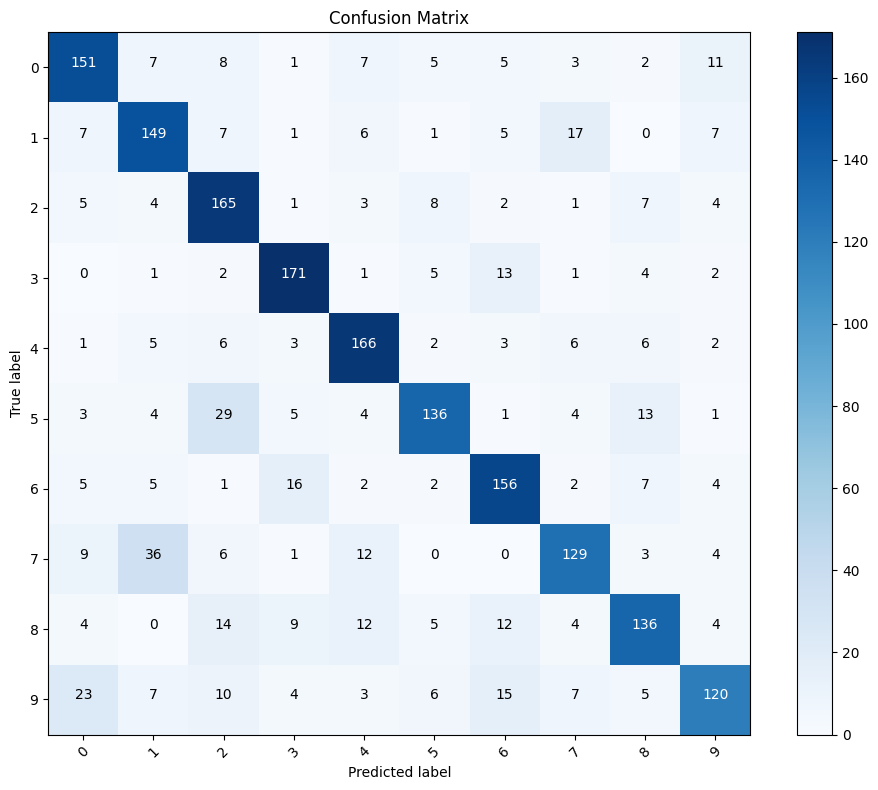

In [22]:
import wandb
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader

# Define test transform
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load test dataset
test_dataset = datasets.ImageFolder(
    root='/kaggle/working/inaturalist_12K/val',  # <-- Update path if needed
    transform=test_transform
)

test_loader = DataLoader(
    test_dataset,
    batch_size=64,  # Use a reasonable batch size
    shuffle=False,
    num_workers=0   # Avoid BrokenPipeError
)

# Fetch the best run from W&B sweep
api = wandb.Api()
sweep = api.sweep(sweep_id)

# Sort runs by highest validation accuracy
best_run = sorted(sweep.runs, key=lambda run: run.summary.get("val_acc", 0), reverse=True)[0]
best_config = best_run.config
print("Best Run ID:", best_run.id)
print("Best Val Accuracy:", best_run.summary["val_acc"])
print("Best Config:", best_config)

# Get the trainable_layers parameter from the best config
trainable_layers = best_config.get('trainable_layers', 1)  # Default to 1 if not found

# Determine the correct model file to download based on the best config
# The model filename now includes the number of trainable layers
model_filename = f"best_model_layers{trainable_layers}.pth"
try:
    # Try to download the model with the new naming convention
    model_path = best_run.file(model_filename).download(exist_ok=True).name
    print(f"Downloaded model: {model_filename}")
except Exception as e:
    # Fall back to the default name if the specific file isn't found
    print(f"Could not find {model_filename}, falling back to default name.")
    model_path = best_run.file("best_model.pth").download(exist_ok=True).name
    print(f"Downloaded model: best_model.pth")

# Re-instantiate model with the same architecture as during training
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# Initially freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace the final fully connected layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

# If needed for evaluation, unfreeze the same layers that were trained
# This isn't strictly necessary for inference, but ensures the model setup matches training
if trainable_layers > 1:  # If more than just the FC layer was trained
    # Get a list of all model layers
    layers = [
        model.conv1, model.bn1, model.relu, model.maxpool,  # Initial layers
        model.layer1,  # Layer 1
        model.layer2,  # Layer 2
        model.layer3,  # Layer 3
        model.layer4,  # Layer 4
        model.avgpool,  # Average pooling
        model.fc      # Final fully connected layer
    ]
    
    # Unfreeze the last k layers as in training
    trainable_layers_list = layers[-trainable_layers:]
    for layer in trainable_layers_list:
        for param in layer.parameters():
            param.requires_grad = True
    
    print(f"Model configured with {trainable_layers} trainable layers from the end")

# Load the saved model weights
model.load_state_dict(torch.load(model_path))
model.eval()

# Move model to appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(f"Using device: {device}")

# Evaluate on test set
def evaluate_on_test(model, loader):
    correct = 0
    total = 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    
    class_correct = [0] * 10
    class_total = [0] * 10
    
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            # Per-class accuracy
            for i in range(targets.size(0)):
                label = targets[i]
                pred = predicted[i]
                if label == pred:
                    class_correct[label] += 1
                class_total[label] += 1
    
    # Overall accuracy
    test_acc = 100. * correct / total
    print(f"Test Accuracy: {test_acc:.2f}%")
    
    # Per-class accuracy
    print("Per-class accuracy:")
    for i in range(10):
        class_acc = 100. * class_correct[i] / class_total[i] if class_total[i] > 0 else 0
        print(f"Class {i}: {class_acc:.2f}%")
    
    # Log to wandb if desired
    if wandb.run is not None:
        wandb.log({
            "test_accuracy": test_acc,
            "per_class_accuracy": {f"class_{i}": 100. * class_correct[i] / class_total[i] 
                                  if class_total[i] > 0 else 0 for i in range(10)}
        })
    
    return test_acc, class_correct, class_total

# Run the evaluation
print("\nEvaluating model on test set...")
test_acc, class_correct, class_total = evaluate_on_test(model, test_loader)

# Print a summary
print("\nModel Summary:")
print(f"Best Run ID: {best_run.id}")
print(f"Number of trainable layers: {trainable_layers}")
print(f"Best validation accuracy: {best_run.summary['val_acc']:.2f}%")
print(f"Test accuracy: {test_acc:.2f}%")

# Optional: Additional analysis
try:
    # If you want to create a confusion matrix or more detailed analysis
    import matplotlib.pyplot as plt
    import numpy as np
    from sklearn.metrics import confusion_matrix
    
    # Function to get all predictions for confusion matrix
    def get_all_predictions(model, loader):
        all_targets = []
        all_preds = []
        model.eval()
        with torch.no_grad():
            for inputs, targets in loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                all_targets.extend(targets.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())
        return np.array(all_targets), np.array(all_preds)
    
    # Get predictions
    targets, predictions = get_all_predictions(model, test_loader)
    
    # Create confusion matrix
    cm = confusion_matrix(targets, predictions)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    classes = [str(i) for i in range(10)]
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    # Add text annotations
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
    # Save the confusion matrix
    plt.savefig('confusion_matrix.png')
    
    # Log to wandb if desired
    if wandb.run is not None:
        wandb.log({"confusion_matrix": wandb.Image('confusion_matrix.png')})
    
    print("Confusion matrix saved as 'confusion_matrix.png'")
except Exception as e:
    print(f"Could not create confusion matrix: {e}")